In [1]:
import numpy as np
import pandas as pd
import statistics as stat
from astropy.io import fits
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture # for GMM clustering
from sklearn import metrics # for calculating Silhouette score
from scipy.stats import norm
import time

## 1. Set up data for CSV file

In [2]:
# Read in FITS file

visit_hdus = fits.open('allVisit-r12-l33.fits')

# print(visit_hdus.info())

In [3]:
# HDU stuff

visit_header = visit_hdus[1].header
visit_data = visit_hdus[1].data

visit_hdus.close()

# print(visit_header)

In [4]:
# Set up variables for FITS file data

all_targets = list(visit_data['TARGET_ID'])
all_mjd = list(visit_data['MJD'])
all_obsvhelio = list(visit_data['OBSVHELIO']) # Heliocentric relative RV from 'observed spectrum template matching'
all_obsvrelerr = list(visit_data['OBSVRELERR']) # RV error of OBSVREL
all_plates = list(visit_data['PLATE'])

In [5]:
# Create pandas dataframe for all data

all_data = [all_targets, all_plates, all_mjd, all_obsvhelio, all_obsvrelerr]

df = pd.DataFrame(all_data).transpose()
df.columns = ['Target ID', 'Plate ID', 'MJD', 'OBSVHELIO (km/s)', 'OBSVREL Error (km/s)']

In [6]:
# Show all relevant FITS file data

df.sort_values('OBSVHELIO (km/s)')

Target ID      Plate ID    MJD  \
1106307  apo25m.5118.URMINOR.2M15062489+6715577          8628  58298   
467533    lco25m.5214.CARINA.2M06472679-5057077         10209  58212   
786088    apo25m.4503.160+60.2M11002078+4809563          7348  56729   
1026410  apo25m.5748.BOOTES1.2M13544089+1520421         10894  58292   
1108939  apo25m.5118.URMINOR.2M15075464+6710445          8628  57468   
...                                         ...           ...    ...   
47659       lco25m.5499.SMC3.2M00375577-7343181         10083  58028   
380012    apo25m.4568.191-04.2M05522126+1734585          6762  56565   
380013    apo25m.4568.191-04.2M05522126+1734585          6762  56566   
1696691      apo25m.5110.M15.2M21293076+1206327          8706  58296   
499049    apo25m.4293.235-06.2M07123153-2203550          5614  56255   

        OBSVHELIO (km/s) OBSVREL Error (km/s)  
1106307     -1768.998169             0.355434  
467533      -1640.690063             0.105672  
786088      -1628.462891             0.217651  
1026410     -1616.208618              0.18248  
1108939     -1580.105103             0.262306  
...                  ...                  ...  
47659           999999.0             999999.0  
380012          999999.0             999999.0  
380013          999999.0             999999.0  
1696691         999999.0             999999.0  
499049          999999.0             999999.0  

[1778792 rows x 5 columns]

In [7]:
# Drop bad RV and RV error values

df_cutoff = df.loc[(df['OBSVHELIO (km/s)'] < 3000) & (df['OBSVREL Error (km/s)'] != 0) & (df['OBSVHELIO (km/s)'] > -3000)]

In [8]:
df_cutoff.sort_values('OBSVHELIO (km/s)', ascending=False)

Target ID      Plate ID    MJD  \
725084   apo25m.5270.ORPHAN-3.2M10123304+2625481          9691  57821   
725085   apo25m.5270.ORPHAN-3.2M10123304+2625481          9691  57826   
725073   apo25m.5270.ORPHAN-3.2M10123304+2625481          9663  57819   
725078   apo25m.5270.ORPHAN-3.2M10123304+2625481          9681  57820   
725074   apo25m.5270.ORPHAN-3.2M10123304+2625481          9663  57822   
...                                          ...           ...    ...   
1108939   apo25m.5118.URMINOR.2M15075464+6710445          8628  57468   
1026410   apo25m.5748.BOOTES1.2M13544089+1520421         10894  58292   
786088     apo25m.4503.160+60.2M11002078+4809563          7348  56729   
467533     lco25m.5214.CARINA.2M06472679-5057077         10209  58212   
1106307   apo25m.5118.URMINOR.2M15062489+6715577          8628  58298   

        OBSVHELIO (km/s) OBSVREL Error (km/s)  
725084       1645.694458             0.391225  
725085       1631.672119             0.468834  
725073       1520.107666             0.132766  
725078        1519.69812             0.121078  
725074        1518.61145             0.111901  
...                  ...                  ...  
1108939     -1580.105103             0.262306  
1026410     -1616.208618              0.18248  
786088      -1628.462891             0.217651  
467533      -1640.690063             0.105672  
1106307     -1768.998169             0.355434  

[1730348 rows x 5 columns]

In [9]:
# Identify list of unique targets

unique_targets = Counter(df_cutoff['Target ID'])
unique_targets_list = unique_targets.keys()

In [10]:
len(unique_targets)

481336

In [11]:
# Create list of RV_j values

RV_j = list(df_cutoff['OBSVHELIO (km/s)'])

In [12]:
# Calculate <RV>, i.e. weighted RV_j values

t0 = time.process_time()
weightedRVs = []

for target in unique_targets_list:
    target_df = df_cutoff[df_cutoff['Target ID'] == target]
    #print('target_df time:', (time.process_time() - t0))
    targetRV_j = list(target_df['OBSVHELIO (km/s)'])
    #print('targetRV_j time:', (time.process_time() - t0))
    sigma = list(target_df['OBSVREL Error (km/s)'])
    #print('sigma time:', (time.process_time() - t0))
    weight = [1 / (sigma[s]**2) for s in range(len(sigma))]
    #print('weight calc time:', (time.process_time() - t0))
    weightedavg = sum([targetRV_j[i] * weight[i] for i in range(len(targetRV_j))]) / sum(weight)
    #print('weighted avg calc time:', (time.process_time() - t0))
    for j in range(len(targetRV_j)):
        weightedRVs.append(weightedavg)
        #print('weighted avg append time:', (time.process_time() - t0))
    #print('single loop time:', (time.process_time() - t0))
print('total loop time:', (time.process_time() - t0))

total loop time: 40228.918379


In [13]:
len(weightedRVs)

1730348

In [14]:
# Append <RV> values to dataframe

df_cutoff['<RV>'] = weightedRVs

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2527/3472661335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoff['<RV>'] = weightedRVs


In [15]:
# Calculate ΔRV_j = RV_j - < RV >

deltaRV_j = [RV_j[i] - weightedRVs[i] for i in range(len(RV_j))]

In [16]:
# Append ΔRV_j values to dataframe as ΔRV

df_cutoff['ΔRV'] = deltaRV_j

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2527/418557115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoff['ΔRV'] = deltaRV_j


In [17]:
# Check updated dataframe

df_cutoff.sort_values('ΔRV', ascending=False)

Target ID      Plate ID    MJD  \
54837      apo25m.5478.ANDR3.AP00423886+4114092         10088  58087   
54839      apo25m.5478.ANDR3.AP00423886+4114092         10088  58091   
54841      apo25m.5478.ANDR3.AP00423886+4114092         10088  58114   
54843      apo25m.5478.ANDR3.AP00423886+4114092         10305  58117   
1304103    apo25m.5188.DRACO.2M17211457+5752139          9007  57524   
...                                         ...           ...    ...   
1106307  apo25m.5118.URMINOR.2M15062489+6715577          8628  58298   
54832      apo25m.5478.ANDR3.AP00423886+4118342         10088  58083   
54836      apo25m.5478.ANDR3.AP00423886+4118342         10088  58087   
54834      apo25m.5478.ANDR3.AP00423886+4118342         10088  58086   
54826      apo25m.5478.ANDR3.AP00423886+4118342         10088  58058   

        OBSVHELIO (km/s) OBSVREL Error (km/s)         <RV>          ΔRV  
54837        1026.774536             0.026893  -368.419066  1395.193602  
54839        1024.719116             0.029735  -368.419066  1393.138182  
54841         823.579773             0.361824  -368.419066  1191.998839  
54843         799.057861             0.153719  -368.419066  1167.476927  
1304103       281.131226             0.902491  -879.470929  1160.602155  
...                  ...                  ...          ...          ...  
1106307     -1768.998169             0.355434  -545.180241 -1223.817928  
54832        -367.633789             0.053552  1021.901399 -1389.535188  
54836        -368.844543             0.080999  1021.901399 -1390.745942  
54834        -369.080475             0.100251  1021.901399 -1390.981874  
54826         -370.20282             0.201564  1021.901399 -1392.104219  

[1730348 rows x 7 columns]

In [18]:
df_cutoff.to_csv('all_RVs.csv')

## 2. Analysis of data from CSV file

In [2]:
# Read in CSV file

df_cutoff = pd.read_csv('all_RVs.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
df_cutoff

Target ID      Plate ID    MJD  \
0                             apo1m.1.Bestars.       Bestars  58017   
1                             apo1m.1.Bestars.       Bestars  58022   
2                    apo1m.1.calibration.VESTA   calibration  56398   
3                    apo1m.1.calibration.VESTA   calibration  56778   
4                         apo1m.1.calibration.   calibration  57743   
...                                        ...           ...    ...   
1730343  apo25m.4424.116-04.2M23595886+5726058          5583  56261   
1730344  apo25m.4424.116-04.2M23595886+5726058          5583  56284   
1730345  apo25m.4548.105-45.2M23595980+1528407          6560  56584   
1730346  apo25m.4548.105-45.2M23595980+1528407          6560  56588   
1730347  apo25m.4548.105-45.2M23595980+1528407          6560  56613   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)        <RV>        ΔRV  
0             -523.166440              0.234950 -525.619404   2.452961  
1             -526.084350              0.102290 -525.619404  -0.464947  
2               25.553330              0.018306   14.014931  11.538398  
3               10.561789              0.010014   14.014931  -3.453142  
4              -36.204376              0.003971  -36.204376   0.000000  
...                   ...                   ...         ...        ...  
1730343        -60.935745              0.012662  -60.924493  -0.011252  
1730344        -60.901040              0.019322  -60.924493   0.023454  
1730345         -5.201384              0.050281   -5.175535  -0.025849  
1730346         -5.034553              0.066701   -5.175535   0.140983  
1730347         -5.517447              0.126213   -5.175535  -0.341911  

[1730348 rows x 7 columns]

(80.0, -80.0)

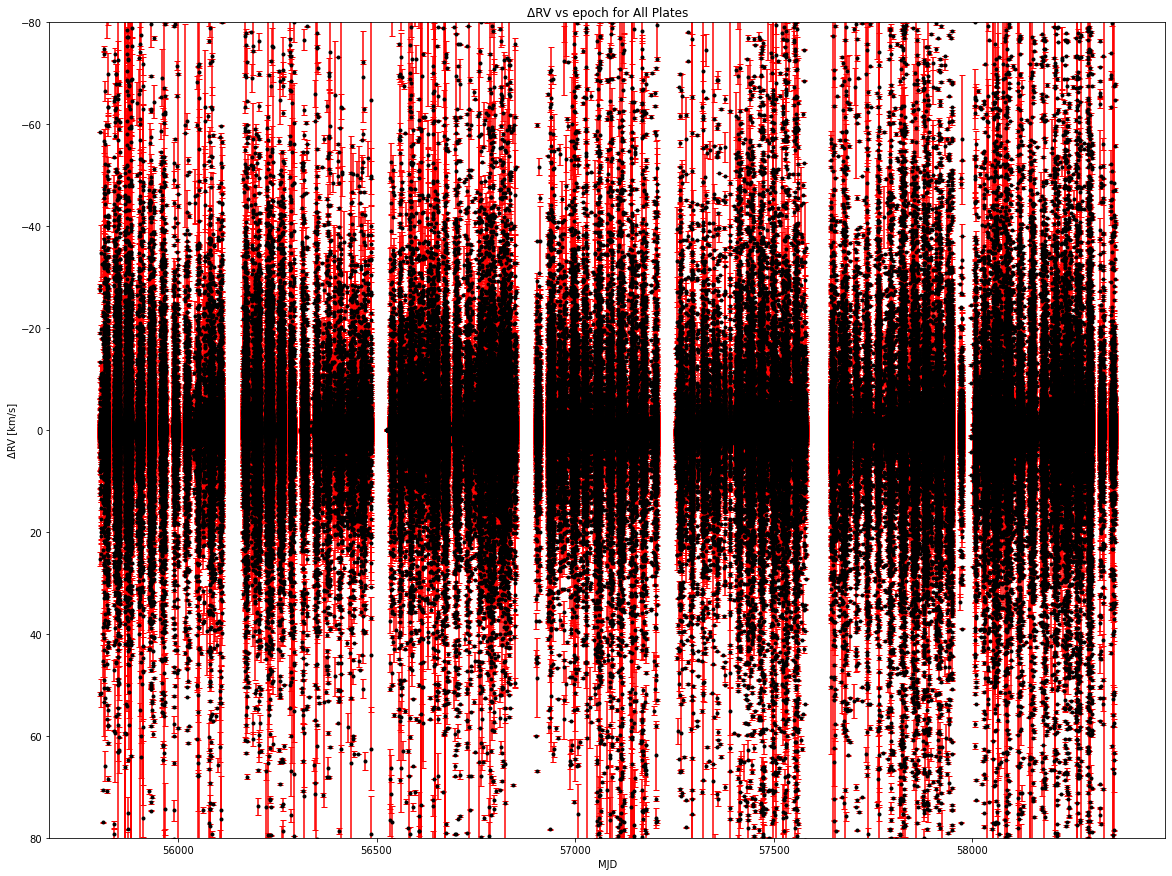

In [4]:
x = df_cutoff['MJD']
y = df_cutoff['ΔRV']
yerr = df_cutoff['OBSVREL Error (km/s)']
plt.figure(figsize=(20, 15))
plt.errorbar(x, y, yerr, fmt='.', capsize=3, color='black', ecolor='r')
plt.title('ΔRV vs epoch for All Plates')
plt.xlabel('MJD')
plt.ylabel('ΔRV [km/s]')
plt.ylim(80, -80)

In [5]:
# Identify list of unique MJDs

unique_mjd = Counter(df_cutoff['MJD'])
unique_mjd_list = unique_mjd.keys()

In [6]:
len(unique_mjd_list)

1526

In [7]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs = []
combined_staterror = []
t1 = time.process_time()

for mjd in unique_mjd_list:
    mjd_df = df_cutoff[df_cutoff['MJD'] == mjd]
    #print('mjd_df time:', (time.process_time()-t1))
    mjd_RVs = list(mjd_df['ΔRV'])
    #print('mjd_RVs time:', (time.process_time()-t1))
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    #print('mjd_sigma time:', (time.process_time()-t1))
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    #print('weight calc time:', (time.process_time()-t1))
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    #print('sigma calc time:', (time.process_time()-t1))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    # print('Sum of weights:', sum(weight))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    #print('combined weighted avg calc time:', (time.process_time()-t1))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs.append(combined_weightedavg)
    #print('combined avg append time:', (time.process_time()-t1))
    combined_staterror.append(sigmaRV)
    #print('combined stat error append time:', (time.process_time()-t1))
print('total time:', (time.process_time()-t1))

total time: 6.413353999999998


In [8]:
# Create dataframe for MJD and combined weighted ΔRV values

weightedavg_data = [unique_mjd_list, combined_weightedRVs, combined_staterror]
weightedavg_df = pd.DataFrame(weightedavg_data).transpose()
weightedavg_df.columns = ['MJD', 'Combined ΔRV (m/s)', 'Combined σRV (m/s)']

In [9]:
weightedavg_df

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)
0     58017.0           18.532673            0.516441
1     58022.0           -7.037739            0.406064
2     56398.0           32.209356            0.390692
3     56778.0        -3390.358293            9.925159
4     57743.0            0.023227            2.212728
...       ...                 ...                 ...
1521  55870.0         -747.353620            0.877595
1522  56617.0          407.050243            1.423239
1523  56625.0          380.012824            0.524959
1524  56576.0           61.801196            0.568926
1525  56482.0          408.837184            0.694695

[1526 rows x 3 columns]

Gradient of slope: 0.07369522906907566 [m/MJD]
Polynomial coefficients: 0.07369522906907566 -4292.960080074415
Covariance matrix: [[ 1.43190827e-04 -8.33309895e+00]
 [-8.33309895e+00  4.84967464e+05]]
Uncertainty: [1.19662370e-02 6.96396054e+02]


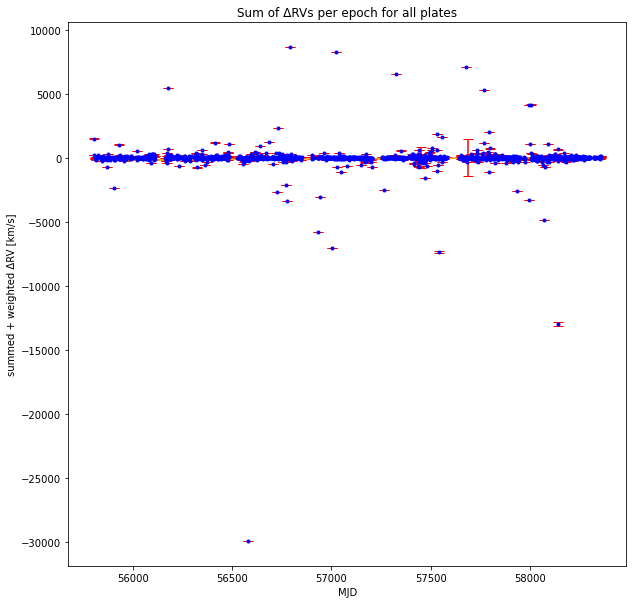

In [10]:
x_c = weightedavg_df['MJD']
y_c = weightedavg_df['Combined ΔRV (m/s)']
yerr_c = weightedavg_df['Combined σRV (m/s)']

weights = 1/(yerr_c**2)
model, cov = np.polyfit(x_c, y_c, deg=1, w=weights, cov=True)
a, b = model

# Scatterplot of combined total ΔRVs per epoch for all plates, with linear fit

plt.figure(figsize=(10, 10))
plt.errorbar(x_c, y_c, yerr_c, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_c, a*x_c+b, color='orange')
plt.title('Sum of ΔRVs per epoch for all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [km/s]')

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

(-500.0, 500.0)

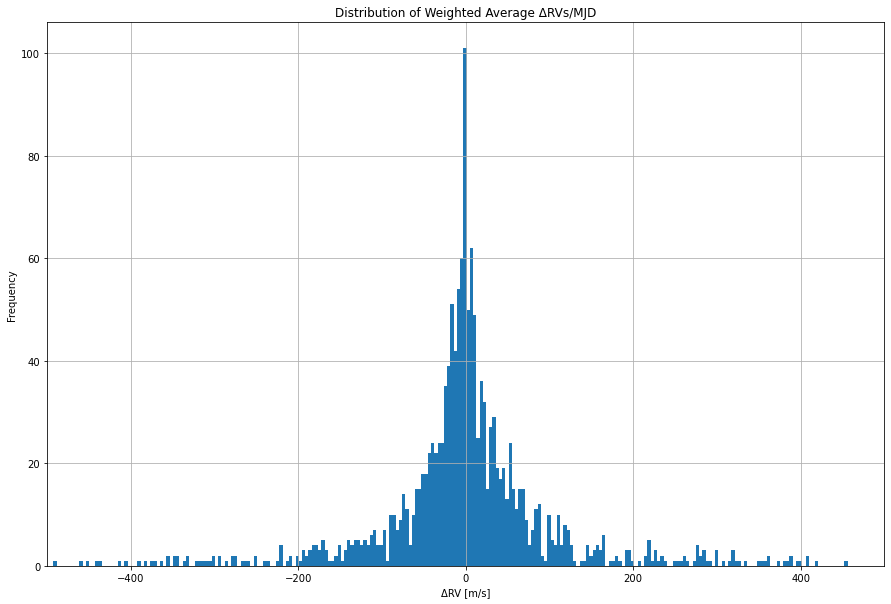

In [11]:
plt.figure(figsize=(15, 10))
weightedavg_df['Combined ΔRV (m/s)'].plot.hist(grid=True, bins=10000, rwidth=1)
plt.title('Distribution of Weighted Average ΔRVs/MJD')
plt.xlabel('ΔRV [m/s]')
plt.xlim(-500, 500)
#plt.ylim(0, 150000)

In [12]:
'''# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

# Select data for clustering model
X = df_cutoff[['OBSVREL Error (km/s)', 'ΔRV']]

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()'''

"# Create empty list\nS=[]\n\n# Range of clusters to try (2 to 10)\nK=range(2,11)\n\n# Select data for clustering model\nX = df_cutoff[['OBSVREL Error (km/s)', 'ΔRV']]\n\nfor k in K:\n    # Set the model and its parameters\n    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')\n    # Fit the model \n    labels = model.fit_predict(X)\n    # Calculate Silhoutte Score and append to a list\n    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))\n\n# Plot the resulting Silhouette scores on a graph\nplt.figure(figsize=(16,8), dpi=300)\nplt.plot(K, S, 'bo-', color='black')\nplt.xlabel('k')\nplt.ylabel('Silhouette Score')\nplt.title('Identify the number of clusters using Silhouette Score')\nplt.show()"

(0.0, 150000.0)

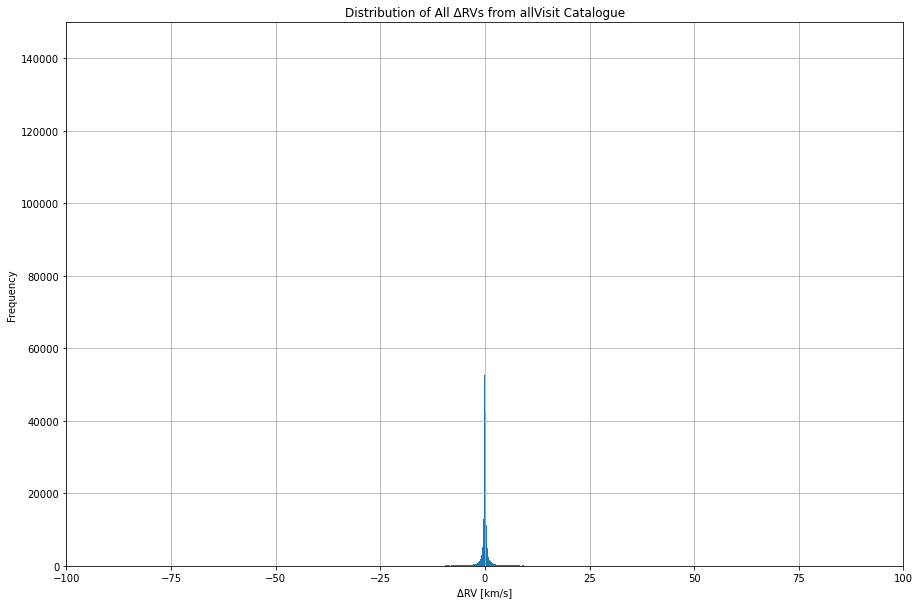

In [13]:
plt.figure(figsize=(15, 10))
df_cutoff['ΔRV'].plot.hist(grid=True, bins=100000, rwidth=1)
plt.title('Distribution of All ΔRVs from allVisit Catalogue')
plt.xlabel('ΔRV [km/s]')
plt.xlim(-100, 100)
plt.ylim(0, 150000)

In [14]:
# Select data for clustering model
X = df_cutoff[['OBSVREL Error (km/s)', 'ΔRV']]

# Set the model and its parameters - 2 clusters
model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=1000, # the number of EM iterations to perform. default=100
                         n_init=10, # the number of initializations to perform. default = 1
                         init_params='random', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust2 = model.fit(X)
labels2 = model.predict(X)

# Generate 10,000 new samples based on the model
smpl=model.sample(n_samples=10000)

# Model summary
print('*************** 2 Cluster Model ***************')
print('Weights: ', clust2.weights_)
print('Means: ', clust2.means_)
print('Covariances: ', clust2.covariances_)
print('Precisions: ', clust2.precisions_)
#print('Precisions Cholesky: ', clust2.precisions_cholesky_)
print('Converged: ', clust2.converged_)
print(' No. of Iterations: ', clust2.n_iter_)
print('Lower Bound: ', clust2.lower_bound_)

*************** 2 Cluster Model ***************
Weights:  [0.9355188 0.0644812]
Means:  [[ 8.00270390e-02 -3.93727385e-03]
 [ 7.73090869e+07 -6.70191729e-01]]
Covariances:  [[[ 1.33798023e-02 -3.51228399e-04]
  [-3.51228399e-04  8.49121119e-01]]

 [[ 1.97096382e+20 -1.48532254e+10]
  [-1.48532254e+10  6.92250282e+03]]]
Precisions:  [[[7.47403316e+01 3.09154094e-02]
  [3.09154094e-02 1.17770108e+00]]

 [[5.07448038e-21 1.08880275e-14]
  [1.08880275e-14 1.44479785e-04]]]
Converged:  True
 No. of Iterations:  20
Lower Bound:  -2.7722653822646355


In [15]:
# Attach cluster labels to the main dataframe
df_cutoff['Cluster']=labels2

In [16]:
df0 = df_cutoff[df_cutoff['Cluster'] == 0]
df1 = df_cutoff[df_cutoff['Cluster'] == 1]

In [17]:
df0

Target ID      Plate ID    MJD  \
0                             apo1m.1.Bestars.       Bestars  58017   
1                             apo1m.1.Bestars.       Bestars  58022   
3                    apo1m.1.calibration.VESTA   calibration  56778   
4                         apo1m.1.calibration.   calibration  57743   
5        apo25m.5046.120+12.2M00000002+7417074          7545  56933   
...                                        ...           ...    ...   
1730343  apo25m.4424.116-04.2M23595886+5726058          5583  56261   
1730344  apo25m.4424.116-04.2M23595886+5726058          5583  56284   
1730345  apo25m.4548.105-45.2M23595980+1528407          6560  56584   
1730346  apo25m.4548.105-45.2M23595980+1528407          6560  56588   
1730347  apo25m.4548.105-45.2M23595980+1528407          6560  56613   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)        <RV>       ΔRV  Cluster  
0             -523.166440              0.234950 -525.619404  2.452961        0  
1             -526.084350              0.102290 -525.619404 -0.464947        0  
3               10.561789              0.010014   14.014931 -3.453142        0  
4              -36.204376              0.003971  -36.204376  0.000000        0  
5              -51.673046              0.001443  -51.727627  0.054581        0  
...                   ...                   ...         ...       ...      ...  
1730343        -60.935745              0.012662  -60.924493 -0.011252        0  
1730344        -60.901040              0.019322  -60.924493  0.023454        0  
1730345         -5.201384              0.050281   -5.175535 -0.025849        0  
1730346         -5.034553              0.066701   -5.175535  0.140983        0  
1730347         -5.517447              0.126213   -5.175535 -0.341911        0  

[1618036 rows x 8 columns]

Text(0.5, 0, 'ΔRV [m/s]')

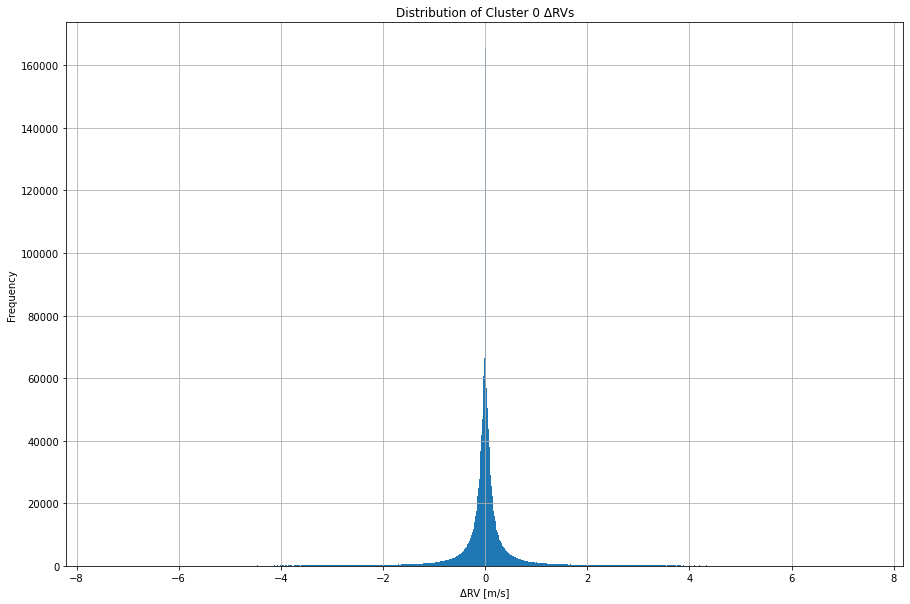

In [18]:
plt.figure(figsize=(15, 10))
df0['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1)
plt.title('Distribution of Cluster 0 ΔRVs')
plt.xlabel('ΔRV [m/s]')
#plt.xlim(-500, 500)
#plt.ylim(0, 150000)

mu: -0.003854314033457798 std: 0.9127881982888993


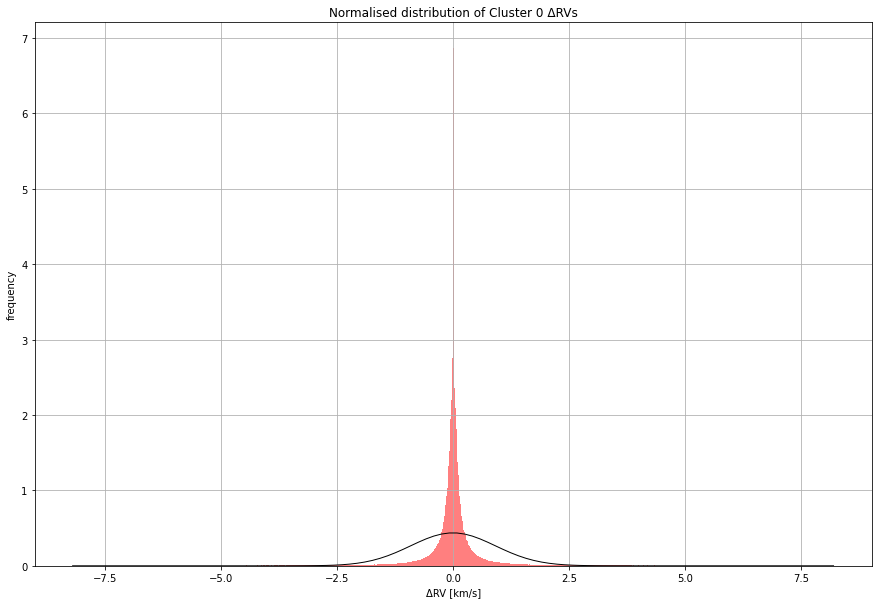

In [19]:
mu0, std0 = norm.fit(df0['ΔRV'])

plt.figure(figsize=(15,10))
plt.hist(x=df0['ΔRV'], bins=1000, alpha=0.5, color='r', label='Cluster 0', density=True)
xmin0, xmax0 = plt.xlim()
x0 = np.linspace(xmin0, xmax0, 100)
p0 = norm.pdf(x0, mu0, std0)  
plt.plot(x0, p0, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of Cluster 0 ΔRVs')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu0, 'std:', std0)

Text(0.5, 0, 'ΔRV [m/s]')

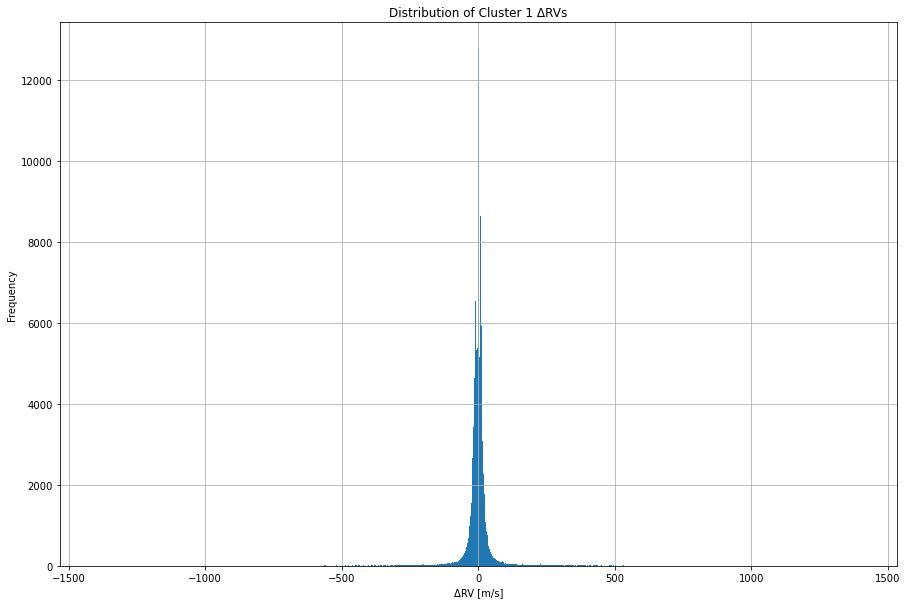

In [20]:
plt.figure(figsize=(15, 10))
df1['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1)
plt.title('Distribution of Cluster 1 ΔRVs')
plt.xlabel('ΔRV [m/s]')
#plt.xlim(-500, 500)
#plt.ylim(0, 150000)

mu: -0.6670143641727447 std: 82.92953568103464


(-500.0, 500.0)

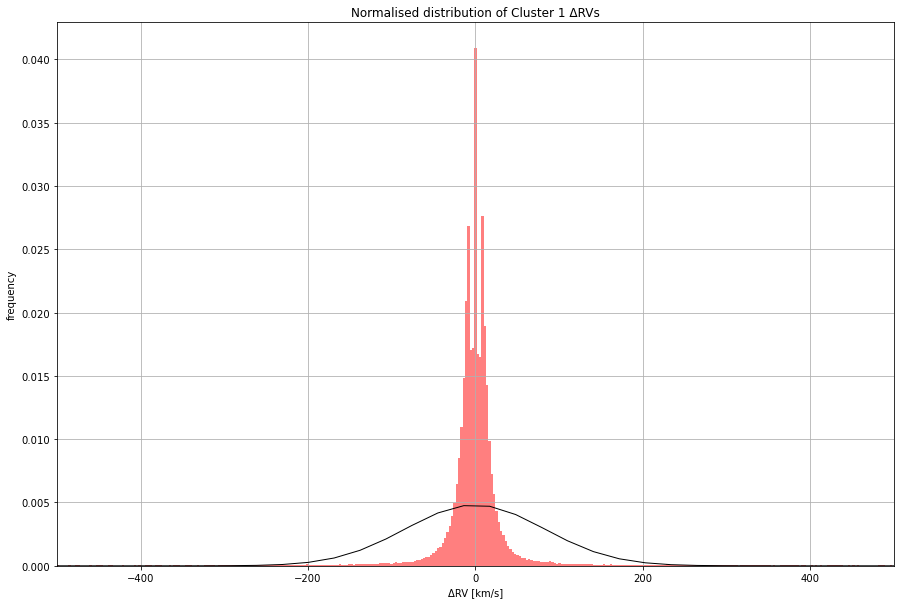

In [21]:
mu1, std1 = norm.fit(df1['ΔRV'])

plt.figure(figsize=(15,10))
plt.hist(x=df1['ΔRV'], bins=1000, alpha=0.5, color='r', label='Cluster 1', density=True)
xmin1, xmax1 = plt.xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)  
plt.plot(x1, p1, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of Cluster 1 ΔRVs')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu1, 'std:', std1)
plt.xlim(-500, 500)

In [22]:
mu0, std0 = norm.fit(df0['ΔRV'])

In [23]:
mu0

-0.003854314033457798

In [24]:
std0

0.9127881982888993

In [25]:
# 95th percentile larger than before?
np.sort(list(np.random.normal(0, std0, 10000000)))[500000]

-1.5006545855974596

In [26]:
# Consider limiting ΔRV range?

df_cut = df_cutoff.loc[(df_cutoff['ΔRV'] < 1.5006843841275197) & (df_cutoff['ΔRV'] > -1.5006843841275197)]
#df_cutoff = df.loc[(df['ΔRV'] < 1) & (df['ΔRV'] > -1)]
df_cut.sort_values('ΔRV')

Target ID      Plate ID    MJD  \
840284       lco25m.5254.300-12.2M12074713-7400204          9701  57881   
101171   apo25m.2396.146-46_MGA.2M02002840+1313279          9195  57662   
182918   apo25m.2302.194-44_MGA.2M03402491-0658283          8727  57691   
1688018    lco25m.5448.051-50-O.2M22162068-0923066          9994  58033   
921990       apo25m.5181.120+45.2M13071823+7307590          9068  57827   
...                                            ...           ...    ...   
324417       apo25m.4559.169+04.2M05323978+4101162          6541  56257   
692012     apo25m.5126.ORPHAN-4.2M09554604+3734466          8472  57094   
1020482      apo25m.5186.090+60.2M14253104+4921363          9005  57498   
714004     apo25m.5119.ORPHAN-2.2M10232934+1411052          8120  57056   
1672718      apo25m.5154.100+00.2M21521428+5428429          8691  57652   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)       <RV>       ΔRV  Cluster  
840284           7.127516              0.160403   8.628178 -1.500662        0  
101171          -7.345494              0.069228  -5.844890 -1.500604        0  
182918           0.399978              0.051881   1.900527 -1.500548        0  
1688018         34.684708              0.031783  36.185223 -1.500515        0  
921990         -20.090202              0.203785 -18.589717 -1.500486        0  
...                   ...                   ...        ...       ...      ...  
324417          -2.179410              0.456571  -3.680050  1.500640        0  
692012          21.122200              0.466716  19.621553  1.500647        0  
1020482        -10.880820              0.317963 -12.381471  1.500651        0  
714004         -31.397923              0.298479 -32.898576  1.500653        0  
1672718        -25.788550              0.111122 -27.289217  1.500667        0  

[1537042 rows x 8 columns]

In [27]:
# Identify list of unique MJDs

unique_mjd_cut = Counter(df_cut['MJD'])
unique_mjd_cutlist = unique_mjd_cut.keys()

## Q
1. sqrt(1/n*(sum(x_i^2)))

In [232]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs_cut = []
combined_staterror_cut = []
weights_cut = []
rmserr_cut = []
std_cut = []
stdalt_cut = []
t2 = time.process_time()

for mjd in unique_mjd_cutlist:
    mjd_df = df_cut[df_cut['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    """3 ways of calculating same thing, all <20?"""
    mean = sum(mjd_RVs) / len(mjd_RVs)
    std = np.sqrt(sum((r - mean)**2 for r in mjd_RVs) / len(mjd_RVs))
    std_alt = np.array(mjd_RVs).std()
    rmserr = np.sqrt(((sum(mjd_RVs[r]**2 for r in range(len(mjd_RVs))))/len(mjd_RVs))/len(mjd_RVs))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs_cut.append(combined_weightedavg)
    combined_staterror_cut.append(sigmaRV)
    weights_cut.append(weight)
    rmserr_cut.append(rmserr)
    std_cut.append(std)
    stdalt_cut.append(std_alt)
print('total time:', (time.process_time()-t2))

total time: 6.644241000000079


In [122]:
std_cut

[0.3204506489970067,
 0.027177108666867168,
 0.1925644016112871,
 0.25777064965931173,
 0.2586905733663524,
 0.3073505769365325,
 0.3929007628323678,
 0.26017288021467666,
 0.24629973450416742,
 0.3384802023033588,
 0.3318908945479823,
 0.31432651791579946,
 0.297631786052526,
 0.3070929217931769,
 0.2978825632229528,
 0.340531455509693,
 0.2670052574652644,
 0.3181066517393226,
 0.2623393933890136,
 0.3446836413703848,
 0.2860133717152871,
 0.26676344781045175,
 0.3032792841504287,
 0.2775549146178557,
 0.34152225941383635,
 0.3197372096380117,
 0.2812988696647026,
 0.25994547875994356,
 0.3380954111870707,
 0.26386586883728425,
 0.30293300476236606,
 0.30760412931305486,
 0.2994511824427207,
 0.346081962763314,
 0.31440630145102305,
 0.22751340115160665,
 0.29449510064209333,
 0.23364832200941998,
 0.32453224519265905,
 0.32135652680878457,
 0.27881172974818563,
 0.3162851031538834,
 0.2696217874397137,
 0.25413487729941786,
 0.28869970161775727,
 0.3649215132078363,
 0.2827018006520

In [96]:
mjd57881 = df_cut[df_cut['MJD']==57881]
mjd57881

Target ID      Plate ID    MJD  \
759537         apo25m.5178.240+60.2M10573799+1102293          9682  57881   
759589         apo25m.5178.240+60.2M10573825+1114000          9682  57881   
759684         apo25m.5178.240+60.2M10574087+1130447          9682  57881   
759845         apo25m.5178.240+60.2M10574676+1121427          9682  57881   
760072         apo25m.5178.240+60.2M10575441+1050479          9682  57881   
...                                              ...           ...    ...   
1495379  apo25m.5202.K2_C7_009-18.2M19234085-2901541          9097  57881   
1495863  apo25m.5202.K2_C7_009-18.2M19234924-2854532          9097  57881   
1496210  apo25m.5202.K2_C7_009-18.2M19235873-2842140          9097  57881   
1496326  apo25m.5202.K2_C7_009-18.2M19240029-2837216          9097  57881   
1496414  apo25m.5202.K2_C7_009-18.2M19240141-2858186          9097  57881   

         OBSVHELIO (km/s)  OBSVREL Error (km/s)       <RV>       ΔRV  Cluster  \
759537          16.843248              0.100377  16.931473 -0.088225        0   
759589          -5.609581              0.094854  -5.752461  0.142880        0   
759684          57.916000              0.133084  58.528448 -0.612448        0   
759845           7.983303              0.111230   7.732044  0.251259        0   
760072          10.720554              0.133484  10.522347  0.198207        0   
...                   ...                   ...        ...       ...      ...   
1495379         83.023570              0.038404  83.128125 -0.104558        0   
1495863         51.318610              0.049897  51.262725  0.055886        0   
1496210         37.842514              0.169680  37.187507  0.655007        0   
1496326          1.709478              0.118738   1.640822  0.068656        0   
1496414        -70.199220              0.152802 -70.342590  0.143371        0   

                          ISO       Weeks     Months  
759537   2017-05-08T00:00:00Z  296.714286  69.233333  
759589   2017-05-08T00:00:00Z  296.714286  69.233333  
759684   2017-05-08T00:00:00Z  296.714286  69.233333  
759845   2017-05-08T00:00:00Z  296.714286  69.233333  
760072   2017-05-08T00:00:00Z  296.714286  69.233333  
...                       ...         ...        ...  
1495379  2017-05-08T00:00:00Z  296.714286  69.233333  
1495863  2017-05-08T00:00:00Z  296.714286  69.233333  
1496210  2017-05-08T00:00:00Z  296.714286  69.233333  
1496326  2017-05-08T00:00:00Z  296.714286  69.233333  
1496414  2017-05-08T00:00:00Z  296.714286  69.233333  

[2131 rows x 11 columns]

In [99]:
sumsq = sum(list(mjd57881['ΔRV'])[r]**2 for r in range(len(list(mjd57881['ΔRV']))))
print('sum of x_i squared=', sumsq)
n = len(list(mjd57881['ΔRV']))
print('n=', n)
rms = sum(list(mjd57881['ΔRV'])[r]**2 for r in range(len(list(mjd57881['ΔRV']))))*1/len(list(mjd57881['ΔRV']))
print('rms=', rms)
err = rms/np.sqrt(len(list(mjd57881['ΔRV'])))

347.12006144828916

In [100]:
len(list(mjd57881['ΔRV']))

2131

In [101]:
sum(list(mjd57881['ΔRV'])[r]**2 for r in range(len(list(mjd57881['ΔRV']))))*1/len(list(mjd57881['ΔRV']))

0.16289069049661623

In [102]:
np.sqrt(0.16289069049661623)

0.40359718841515263

In [103]:
np.sqrt(2131)

46.16275555033516

In [104]:
np.sqrt(0.16289069049661623)/np.sqrt(2131)

0.008742918042989796

In [234]:
# Create dataframe for MJD and combined weighted ΔRV values

weightedavg_cutdata = [unique_mjd_cutlist, combined_weightedRVs_cut, combined_staterror_cut, stdalt_cut, rmserr_cut]
weightedavg_df_cutoff = pd.DataFrame(weightedavg_cutdata).transpose()
weightedavg_df_cutoff.columns = ['MJD', 'Combined ΔRV (m/s)', 'Combined σRV (m/s)', 'std', 'rmserr']

In [235]:
weightedavg_df_cutoff

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std    rmserr
0     58022.0           -8.053015            0.407374  0.320451  0.011893
1     57743.0            0.023227            2.212728  0.027177  0.008194
2     56933.0            9.254238            0.147462  0.192564  0.006334
3     56936.0           23.920864            0.095845  0.257771  0.006028
4     56971.0         -178.377692            0.062524  0.258691  0.006460
...       ...                 ...                 ...       ...       ...
1519  55870.0          -73.029691            0.946294  0.348151  0.024723
1520  56617.0           62.421917            1.511150  0.432546  0.028363
1521  56625.0           11.459281            0.557512  0.309172  0.020794
1522  56576.0           58.248624            0.569609  0.247437  0.016345
1523  56482.0          305.706376            0.724491  0.387252  0.026374

[1524 rows x 5 columns]

Gradient of slope: 0.004035128773501782 [m/s/MJD]
Polynomial coefficients: 0.004035128773501782 -237.00862200604627
Covariance matrix: [[ 4.62674953e-06 -2.67505445e-01]
 [-2.67505445e-01  1.54693388e+04]]
Uncertainty: [2.15098804e-03 1.24375796e+02]


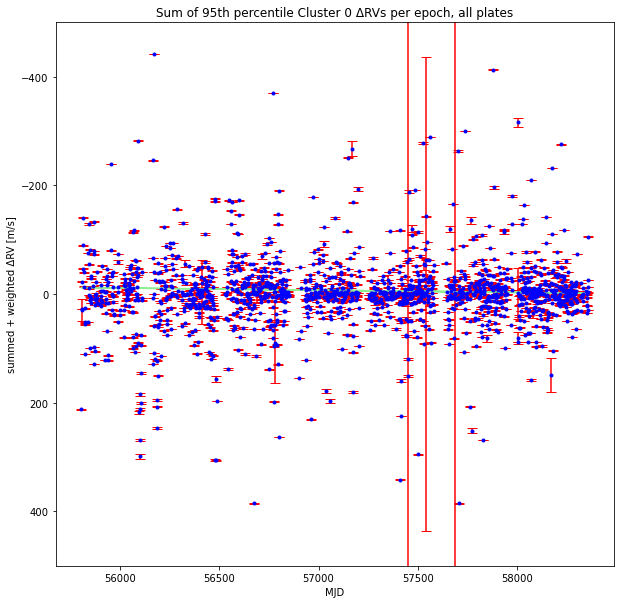

In [186]:
x_cf = weightedavg_df_cutoff['MJD']
y_cf = weightedavg_df_cutoff['Combined ΔRV (m/s)']
#yerr_cf = weightedavg_df_cutoff['Combined σRV (m/s)']
yerr_cf = weightedavg_df_cutoff['std']
weights = 1/(yerr_cf)#**2)
model, cov = np.polyfit(x_cf, y_cf, deg=1, w=weights, cov=True)
a, b = model

# Scatterplot of combined total ΔRVs per epoch, with linear fit

plt.figure(figsize=(10, 10))
plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, a*x_cf+b, color='lightgreen')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/s/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

mu: -2.351556728498106 std: 84.57216100077585


(-200.0, 200.0)

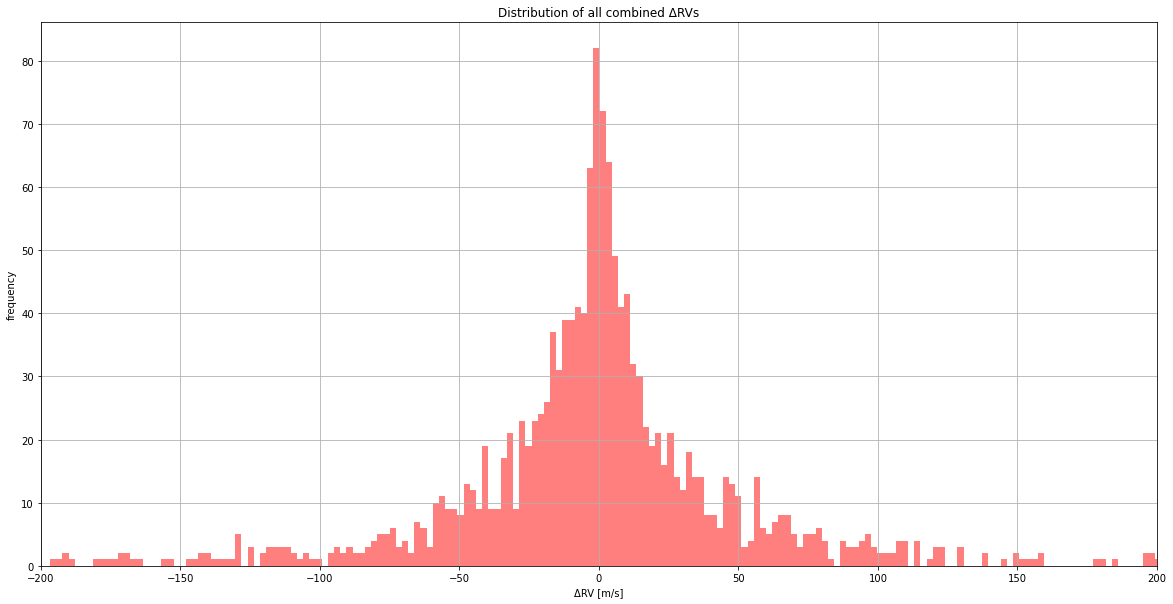

In [32]:
# Normalised weighted distribution of all combined ΔRVs

mua, stda = norm.fit(weightedavg_df_cutoff['Combined ΔRV (m/s)'])

plt.figure(figsize=(20,10))
plt.hist(x=weightedavg_df_cutoff['Combined ΔRV (m/s)'], bins=1000, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
plt.xlim(-200, 200)

In [33]:
# Select data for clustering model
X = weightedavg_df_cutoff[['Combined ΔRV (m/s)', 'Combined σRV (m/s)']]

# Set the model and its parameters - 2 clusters
model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=1000, # the number of EM iterations to perform. default=100
                         n_init=10, # the number of initializations to perform. default = 1
                         init_params='random', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust2 = model.fit(X)
labels2 = model.predict(X)

# Generate 10,000 new samples based on the model
smpl=model.sample(n_samples=10000)

# Model summary
print('*************** 2 Cluster Model ***************')
print('Weights: ', clust2.weights_)
print('Means: ', clust2.means_)
print('Covariances: ', clust2.covariances_)
print('Precisions: ', clust2.precisions_)
#print('Precisions Cholesky: ', clust2.precisions_cholesky_)
print('Converged: ', clust2.converged_)
print(' No. of Iterations: ', clust2.n_iter_)
print('Lower Bound: ', clust2.lower_bound_)

*************** 2 Cluster Model ***************
Weights:  [0.91492412 0.08507588]
Means:  [[-1.66405808  0.44629466]
 [-9.74506315 26.29020088]]
Covariances:  [[[ 1.97838061e+03 -6.13669110e-01]
  [-6.13669110e-01  7.36887526e-02]]

 [[ 6.27357484e+04  4.72861256e+02]
  [ 4.72861256e+02  2.22852701e+04]]]
Precisions:  [[[ 5.06773004e-04  4.22033115e-03]
  [ 4.22033115e-03  1.36057383e+01]]

 [[ 1.59424249e-05 -3.38275239e-07]
  [-3.38275239e-07  4.48798670e-05]]]
Converged:  True
 No. of Iterations:  10
Lower Bound:  -6.2888518305819385


In [34]:
# 95th percentile larger than before?
# Attach cluster labels to the main dataframe
weightedavg_df_cutoff['Cluster']=labels2
df0 = weightedavg_df_cutoff[weightedavg_df_cutoff['Cluster'] == 0]
df1 = weightedavg_df_cutoff[weightedavg_df_cutoff['Cluster'] == 1]
#df0
mu0, std0 = norm.fit(df0['Combined ΔRV (m/s)'])
np.sort(list(np.random.normal(0, std0, 10000000)))[500000]

-72.99478190144039

In [35]:
y0 = df0['Combined ΔRV (m/s)']
y1 = df1['Combined ΔRV (m/s)']
x0 = df0['MJD']
x1 = df1['MJD']

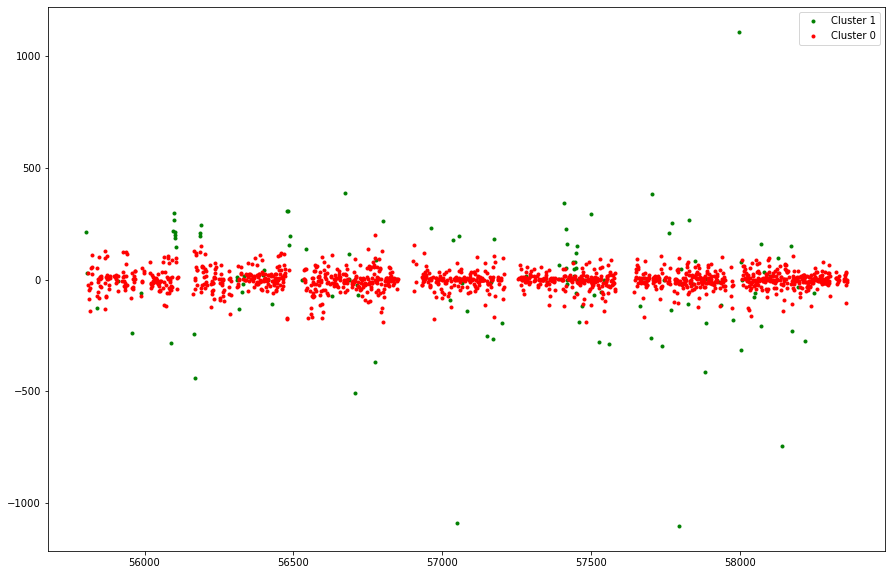

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(x1, y1, '.', color='g', label='Cluster 1')
plt.plot(x0, y0, '.', color='r', label='Cluster 0')
plt.legend()

- try binning (weighted avg all points within a month/week)
- try looking at histogram of all these points to get better sense of things
- try smoothing it (10m/s structure)
- write up what has been done so far
- look at |50m/s| cases --> error may only pop up on some of the plates
- plot looks like combination of 2 cases
- can look at plates 
- n data points, group them in some subsets, fit function to those subsets (box-car average)

## Convert MJD to weeks and months

In [37]:
from astropy import units as u
from astropy.time import Time
from tintervals import conversion

In [243]:
# Convert MJD to weeks and months for df_cut

converted_iso0 = []
for mjd in list(df_cut['MJD']):
    convert = conversion.mjd2iso(mjd)
    converted_iso0.append(convert)
    
converted_epoch_wk0 = []
for mjd in list(df_cut['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*7)
    min_t = 2173.8571428571427
    weeks = convert - min_t
    converted_epoch_wk0.append(weeks)
    
converted_epoch_m0 = []
for mjd in list(df_cut['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*30)
    min_t = 507.23333333333335
    months = convert - min_t
    converted_epoch_m0.append(months)
    
# Convert MJD to weeks and months for weightedavg_df_cutoff

converted_iso = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2iso(mjd)
    converted_iso.append(convert)

converted_epoch_wk = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*7)
    min_t = 2173.8571428571427
    weeks = convert - min_t
    converted_epoch_wk.append(weeks)

converted_epoch_m = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*30)
    min_t = 507.23333333333335
    months = convert - min_t
    converted_epoch_m.append(months)

In [255]:
# Test ΔRVs per 4 weeks

converted_epoch_4wks = []
for mjd in list(weightedavg_df_cutoff['MJD']):
    convert = conversion.mjd2epoch(mjd)/(60*60*24*7*4)
    min_t = 543.4642857142857
    weeks = convert - min_t
    converted_epoch_4wks.append(weeks)

In [256]:
# Attach time labels to the main dataframe

df_cut['ISO']=converted_iso0
df_cut['Weeks']=converted_epoch_wk0
df_cut['Months']=converted_epoch_m0

# Attach cluster labels to the weightedavg dataframe
weightedavg_df_cutoff['ISO']=converted_iso
weightedavg_df_cutoff['Weeks']=converted_epoch_wk
weightedavg_df_cutoff['4 Weeks']=converted_epoch_4wks
weightedavg_df_cutoff['Months']=converted_epoch_m

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_65015/4290082414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['ISO']=converted_iso0
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_65015/4290082414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['Weeks']=converted_epoch_wk0
/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_65015/4290082414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [269]:
max(list(weightedavg_df_cutoff['4 Weeks']))#.sort_values()

91.21428571428578

## Plot ΔRVs per week

0.0
-0.030380526430464964


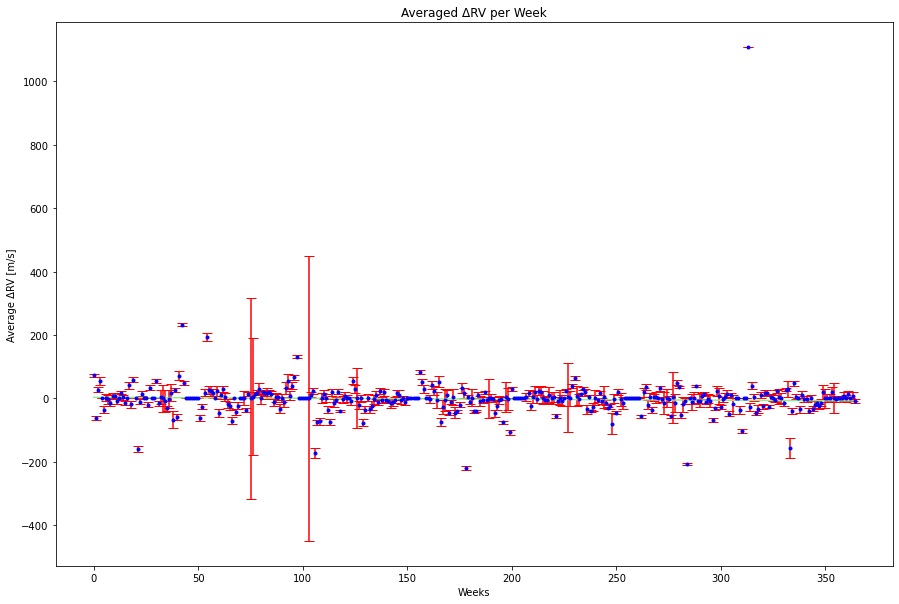

In [266]:
n = 0
p = 1
avg_weeks = []
avg_weeks_err = []
for i in range(0, 365):
    period = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Weeks'] >= n) & (weightedavg_df_cutoff['Weeks'] < p)]
    #print(period)
    weight = len(period['Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_weeks.append(avg)
        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_err = sum(period['std'])/weight #if not divided by N, then order of 1; if divided, then order of 0.1??
        if avg_err == 0:
            print(avg_err)
            avg_weeks_err.append(avg_err)
        else:
            avg_weeks_err.append(1/avg_err**2)
    else:
        avg_weeks.append(0)
        avg_weeks_err.append(0)
    n = n+1
    p = p+1

x = np.arange(0,365)
y = avg_weeks
yerr = avg_weeks_err # 1/σ^2
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('Weeks')
plt.ylabel('Average ΔRV [m/s]')
plt.title('Averaged ΔRV per Week')
#plt.ylim(100, -100)
print(a)

In [270]:
#ΔRVs per 4 weeks

n = 0
p = 1
avg_4weeks = []
avg_4weeks_err = []
for i in range(0, 92):
    period = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['4 Weeks'] >= n) & (weightedavg_df_cutoff['Weeks'] < p)]
    #print(period)
    weight = len(period['4 Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_4weeks.append(avg)
        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_err = sum(period['std'])/weight #if not divided by N, then order of 1; if divided, then order of 0.1??
        if avg_err == 0:
            print(avg_err)
            avg_4weeks_err.append(avg_err)
        else:
            avg_4weeks_err.append(1/avg_err**2)
    else:
        avg_4weeks.append(0)
        avg_4weeks_err.append(0)
    n = n+1
    p = p+1

x = np.arange(0,92)
y = avg_4weeks
yerr = avg_4weeks_err
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('Weeks')
plt.ylabel('Average ΔRV [m/s]')
plt.title('Averaged ΔRV per Week')
plt.ylim(100, -100)
print(a)

LinAlgError: SVD did not converge in Linear Least Squares

mu: -0.1987497745755401 std: 69.64674352762326


(-200.0, 200.0)

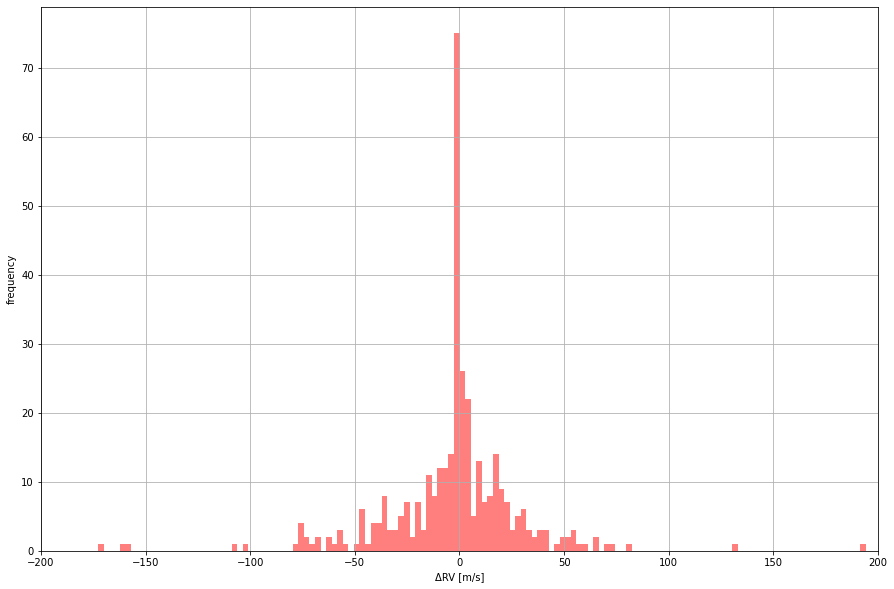

In [53]:
# Distribution of all combined ΔRVs

mua, stda = norm.fit(avg_weeks)

plt.figure(figsize=(15,10))
plt.hist(x=avg_weeks, bins=500, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
#plt.title('Normalised weighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
plt.xlim(-200, 200)

In [54]:
max(list(weightedavg_df_cutoff['Months']))

85.13333333333333

## Plot ΔRVs per 30 days
1. Calculation of error

In [179]:
n = 0
p = 1
avg_30d = []
avg_30derr = []
for i in range(0, 86):
    period = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Months'] >= n) & (weightedavg_df_cutoff['Months'] < p)]
    #print(period)
    weight = len(period['Months'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        #avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_err = sum(period['std'])/weight
        avg_30d.append(avg)
        avg_30derr.append(1/avg_err)
    else:
        avg_30d.append(0)
        avg_30derr.append(0)
    n = n+1
    p = p+1

In [180]:
data_30d = [avg_30d, avg_30derr, list(range(0,86))]
df30d = pd.DataFrame(data_30d).transpose()
df30d.columns = ['Combined ΔRV (m/s)', 'Combined σRV (m/s)', '30 days']

-0.10977639767095666


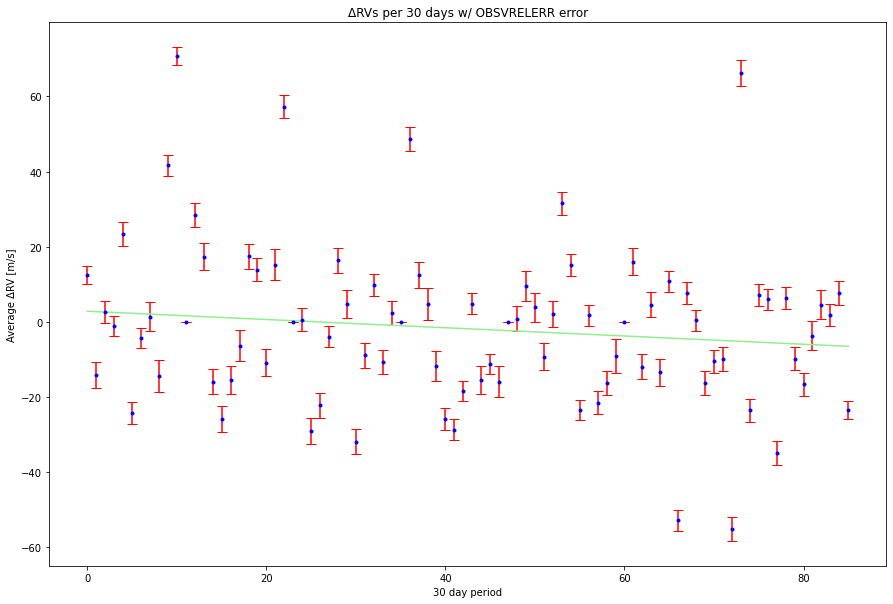

In [181]:
x = np.arange(0,86)
y = avg_30d
yerr = avg_30derr
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days w/ OBSVRELERR error')
#plt.title('ΔRVs per 30 days w/ std error')
print(a)

In [58]:
weightedavg_df_cutoff

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)  Cluster  \
0     58022.0           -8.053015            0.407374        0   
1     57743.0            0.023227            2.212728        1   
2     56933.0            9.254238            0.147462        0   
3     56936.0           23.920864            0.095845        0   
4     56971.0         -178.377692            0.062524        0   
...       ...                 ...                 ...      ...   
1519  55870.0          -73.029691            0.946294        0   
1520  56617.0           62.421917            1.511150        0   
1521  56625.0           11.459281            0.557512        0   
1522  56576.0           58.248624            0.569609        0   
1523  56482.0          305.706376            0.724491        1   

                       ISO       Weeks     Months  
0     2017-09-26T00:00:00Z  316.857143  73.933333  
1     2016-12-21T00:00:00Z  277.000000  64.633333  
2     2014-10-03T00:00:00Z  161.285714  37.633333  
3     2014-10-06T00:00:00Z  161.714286  37.733333  
4     2014-11-10T00:00:00Z  166.714286  38.900000  
...                    ...         ...        ...  
1519  2011-11-05T00:00:00Z    9.428571   2.200000  
1520  2013-11-21T00:00:00Z  116.142857  27.100000  
1521  2013-11-29T00:00:00Z  117.285714  27.366667  
1522  2013-10-11T00:00:00Z  110.285714  25.733333  
1523  2013-07-09T00:00:00Z   96.857143  22.600000  

[1524 rows x 7 columns]

In [59]:
df30d.sort_values('Combined ΔRV (m/s)', ascending=False)

Combined ΔRV (m/s)  Combined σRV (m/s)  30 days
10           70.710266            0.773159     10.0
73           66.208848            7.131398     73.0
22           57.264065            0.825097     22.0
36           48.664008            0.269566     36.0
9            41.614014            0.889135      9.0
..                 ...                 ...      ...
25          -29.120987            0.378423     25.0
30          -31.895297            0.746860     30.0
77          -34.800203            2.906090     77.0
66          -52.775956            0.786580     66.0
72          -55.169518            0.480903     72.0

[86 rows x 3 columns]

In [60]:
df30d.loc[(df30d['Combined ΔRV (m/s)'] >= -10) & (df30d['Combined ΔRV (m/s)'] < 10)]

Combined ΔRV (m/s)  Combined σRV (m/s)  30 days
2             2.697643            0.477113      2.0
3            -1.186353            0.605590      3.0
6            -4.351984            0.955976      6.0
7             1.303221            0.386493      7.0
11            0.000000            0.000000     11.0
17           -6.292934            1.422063     17.0
23            0.000000            0.000000     23.0
24            0.626186            0.654345     24.0
27           -3.939405            0.617257     27.0
29            4.873571            1.373049     29.0
31           -8.896361            0.531395     31.0
32            9.716616            3.197903     32.0
34            2.360192            0.390109     34.0
35            0.000000            0.000000     35.0
38            4.716333            0.356312     38.0
43            4.790994            0.515824     43.0
47            0.000000            0.000000     47.0
48            0.796565            0.419265     48.0
49            9.462662            0.521832     49.0
50            3.835980            0.364518     50.0
51           -9.219451            1.397319     51.0
52            2.125245            0.759769     52.0
56            1.756862            0.736109     56.0
59           -9.006643            0.373162     59.0
60            0.000000            0.000000     60.0
63            4.614723            0.654605     63.0
67            7.681285            0.684929     67.0
68            0.417103            0.727318     68.0
71           -9.957852            0.597945     71.0
75            7.190079            0.731146     75.0
76            5.961054            0.597325     76.0
78            6.347565            1.920758     78.0
79           -9.800121            0.600313     79.0
81           -3.692287            0.447579     81.0
82            4.611561            0.299561     82.0
83            1.744576            0.301044     83.0
84            7.758617            0.287338     84.0

In [61]:
outlier1_df = df_cut.loc[(df_cut['Months'] >= 24) & (df_cut['Months'] < 25)]
outlier1 = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Months'] >= 24) & (weightedavg_df_cutoff['Months'] < 25)]

In [62]:
outlier1

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)  Cluster  \
55    56527.0           -0.381556            2.471352        1   
79    56541.0          -45.674584            0.294438        0   
255   56534.0            0.193084            0.005507        0   
397   56535.0            1.596103            0.272411        0   
398   56536.0           44.306052            0.323282        0   
399   56539.0          -12.694736            0.225414        0   
402   56542.0          138.147373            1.524228        1   
473   56540.0           46.079386            0.409504        0   
564   56543.0           47.773917            0.349045        0   
565   56544.0          -36.417835            0.418746        0   
625   56550.0         -172.609051            1.001908        0   
1445  56537.0           -2.803925            0.556302        0   

                       ISO       Weeks     Months  
55    2013-08-23T00:00:00Z  103.285714  24.100000  
79    2013-09-06T00:00:00Z  105.285714  24.566667  
255   2013-08-30T00:00:00Z  104.285714  24.333333  
397   2013-08-31T00:00:00Z  104.428571  24.366667  
398   2013-09-01T00:00:00Z  104.571429  24.400000  
399   2013-09-04T00:00:00Z  105.000000  24.500000  
402   2013-09-07T00:00:00Z  105.428571  24.600000  
473   2013-09-05T00:00:00Z  105.142857  24.533333  
564   2013-09-08T00:00:00Z  105.571429  24.633333  
565   2013-09-09T00:00:00Z  105.714286  24.666667  
625   2013-09-15T00:00:00Z  106.571429  24.866667  
1445  2013-09-02T00:00:00Z  104.714286  24.433333

In [70]:
sum(outlier1['Combined ΔRV (m/s)']) / len(outlier1['Combined ΔRV (m/s)'])

0.6261858043533564

Text(0, 0.5, 'Frequency')

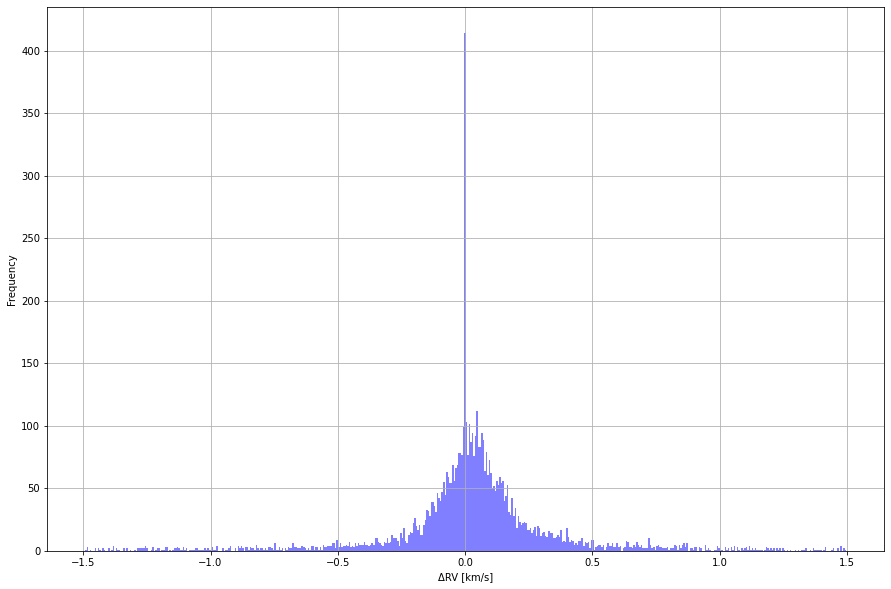

In [72]:
plt.figure(figsize=(15, 10))
#plt.hist(x=outlier1['ΔRV'], bins=10, alpha=0.5, color='r')
plt.hist(x=outlier1_df['ΔRV'], bins=500, alpha=0.5, color='b')
plt.grid()
plt.xlabel('ΔRV [km/s]')
plt.ylabel('Frequency')
#plt.xlim(-0.2, 0.2)

In [73]:
weightedavg_df_cutoff.sort_values('Combined ΔRV (m/s)')

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)  Cluster  \
616   57795.0        -1103.852069            0.352735        1   
527   57050.0        -1090.159679            0.014915        1   
658   58140.0         -744.220229           54.963821        1   
646   56707.0         -509.795698            0.225968        1   
162   56170.0         -440.964379            0.125268        1   
...       ...                 ...                 ...      ...   
1523  56482.0          305.706376            0.724491        1   
366   57409.0          341.656940            0.511530        1   
573   57705.0          384.895401            0.719553        1   
482   56673.0          385.209036            0.185154        1   
1429  57997.0         1108.639519           55.122140        1   

                       ISO       Weeks     Months  
616   2017-02-11T00:00:00Z  284.428571  66.366667  
527   2015-01-28T00:00:00Z  178.000000  41.533333  
658   2018-01-22T00:00:00Z  333.714286  77.866667  
646   2014-02-19T00:00:00Z  129.000000  30.100000  
162   2012-08-31T00:00:00Z   52.285714  12.200000  
...                    ...         ...        ...  
1523  2013-07-09T00:00:00Z   96.857143  22.600000  
366   2016-01-22T00:00:00Z  229.285714  53.500000  
573   2016-11-13T00:00:00Z  271.571429  63.366667  
482   2014-01-16T00:00:00Z  124.142857  28.966667  
1429  2017-09-01T00:00:00Z  313.285714  73.100000  

[1524 rows x 7 columns]

In [225]:
weighted_cut = weightedavg_df_cutoff.loc[(weightedavg_df_cutoff['Combined ΔRV (m/s)'] >= -1000) & (weightedavg_df_cutoff['Combined ΔRV (m/s)'] < 1000)]

In [226]:
weighted_cut.sort_values('Combined ΔRV (m/s)')

MJD  Combined ΔRV (m/s)  Combined σRV (m/s)       std  \
658   58140.0         -744.220229           54.963821  0.070079   
646   56707.0         -509.795698            0.225968  0.312961   
162   56170.0         -440.964379            0.125268  0.354999   
1374  57880.0         -412.599158            0.644058  0.207930   
649   56772.0         -368.990265            0.053932  0.260281   
...       ...                 ...                 ...       ...   
1509  56479.0          305.494082            1.111848  0.449166   
1523  56482.0          305.706376            0.724491  0.387252   
366   57409.0          341.656940            0.511530  0.522980   
573   57705.0          384.895401            0.719553  0.270515   
482   56673.0          385.209036            0.185154  0.303604   

                       ISO       Weeks     Months  
658   2018-01-22T00:00:00Z  333.714286  77.866667  
646   2014-02-19T00:00:00Z  129.000000  30.100000  
162   2012-08-31T00:00:00Z   52.285714  12.200000  
1374  2017-05-07T00:00:00Z  296.571429  69.200000  
649   2014-04-25T00:00:00Z  138.285714  32.266667  
...                    ...         ...        ...  
1509  2013-07-06T00:00:00Z   96.428571  22.500000  
1523  2013-07-09T00:00:00Z   96.857143  22.600000  
366   2016-01-22T00:00:00Z  229.285714  53.500000  
573   2016-11-13T00:00:00Z  271.571429  63.366667  
482   2014-01-16T00:00:00Z  124.142857  28.966667  

[1521 rows x 7 columns]

-0.09377922329108675


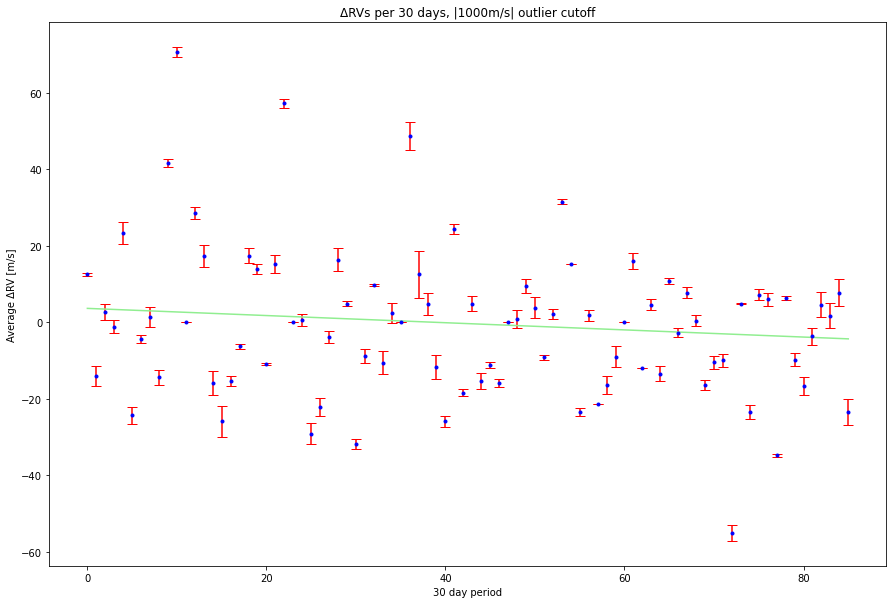

In [228]:
n = 0
p = 1
avg_30d2 = []
avg_30derr2 = []
for i in range(0, 86):
    period = weighted_cut.loc[(weighted_cut['Months'] >= n) & (weighted_cut['Months'] < p)]
    #print(period)
    weight = len(period['Months'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_30d2.append(avg)
        avg_30derr2.append(1/avg_err)
    else:
        avg_30d2.append(0)
        avg_30derr2.append(0)
    n = n+1
    p = p+1

x = np.arange(0,86)
y = avg_30d2
yerr = avg_30derr2
a, b = np.polyfit(x, y, 1, w=yerr)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('30 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per 30 days, |1000m/s| outliers cut')
print(a)

-0.03470343007745003


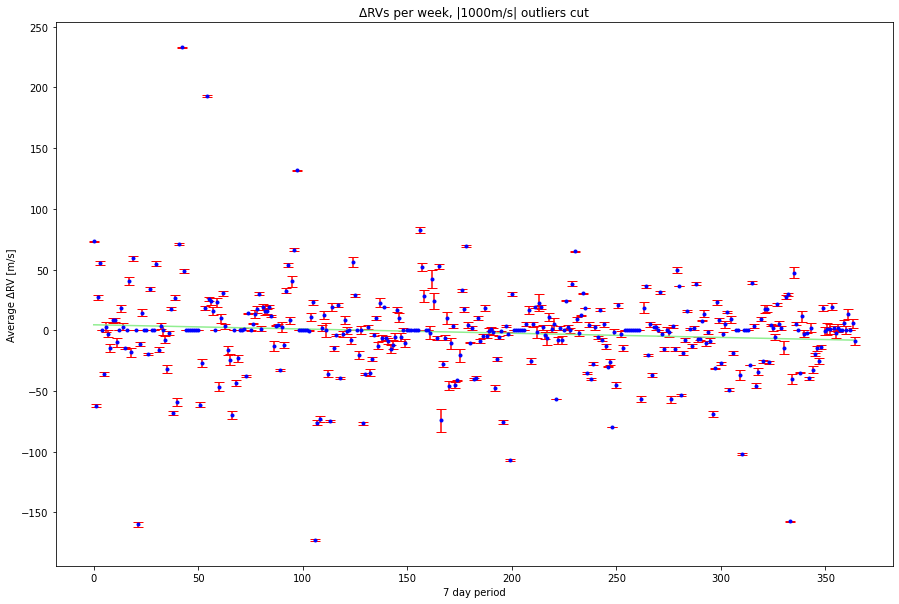

In [230]:
n = 0
p = 1
avg_7d2 = []
avg_7derr2 = []
for i in range(0, 365):
    period = weighted_cut.loc[(weighted_cut['Weeks'] >= n) & (weighted_cut['Weeks'] < p)]
    #print(period)
    weight = len(period['Weeks'])
    if weight > 0:
        avg = sum(period['Combined ΔRV (m/s)'])/weight
        avg_err = sum(period['Combined σRV (m/s)'])/weight
        avg_7d2.append(avg)
        avg_7derr2.append(1/avg_err)
    else:
        avg_7d2.append(0)
        avg_7derr2.append(0)
    n = n+1
    p = p+1

x = np.arange(0,365)
y = avg_7d2
yerr = avg_7derr2
a, b = np.polyfit(x, y, 1)
plt.figure(figsize=(15,10))
#plt.scatter(x, avg_30d)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.xlabel('7 day period')
plt.ylabel('Average ΔRV [m/s]')
plt.title('ΔRVs per week, |1000m/s| outliers cut')
print(a)

mu: -1.3684597899262858 std: 21.56866250739459


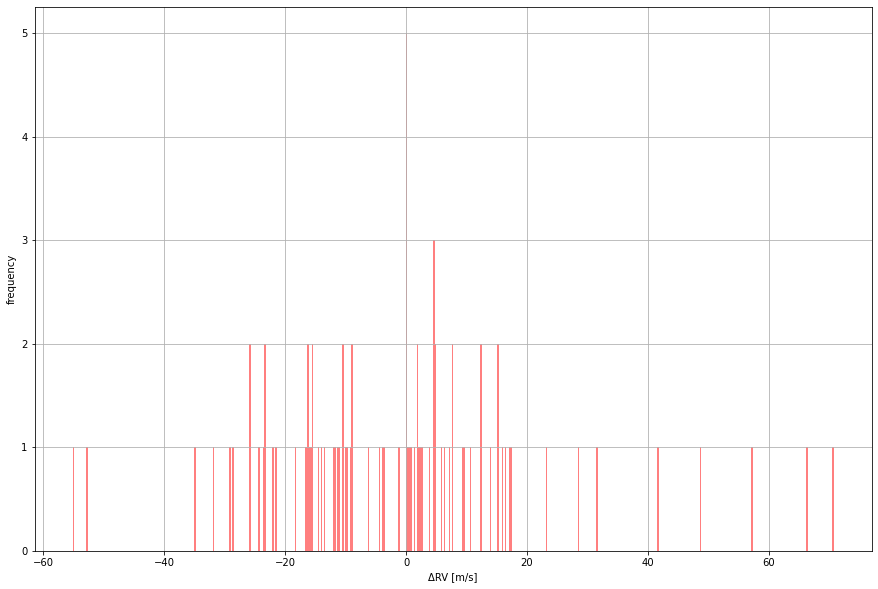

In [54]:
# Distribution of all combined ΔRVs

mua, stda = norm.fit(avg_30d)

plt.figure(figsize=(15,10))
plt.hist(x=avg_30d, bins=500, alpha=0.5, color='r')#, weights=weights)
#xmina, xmaxa = plt.xlim()
#xa = np.linspace(xmina, xmaxa, 100)
#pa = norm.pdf(xa, mua, stda)  
#plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
#plt.title('Normalised weighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)
#plt.xlim(-200, 200)

### Smoothing

In [55]:
from scipy.signal import savgol_filter

Gradient of slope: -5.765416213220513e-05 [m/MJD]
Polynomial coefficients: -5.765416213220513e-05 3.1372373262830506
Covariance matrix: [[ 1.67549701e-07 -9.75131504e-03]
 [-9.75131504e-03  5.67540038e+02]]
Uncertainty: [4.09328353e-04 2.38230988e+01]


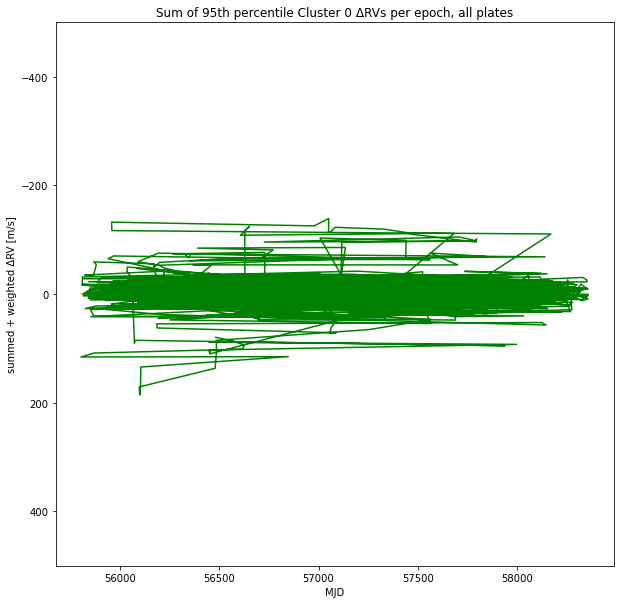

In [56]:
x_cf = weightedavg_df_cutoff['MJD']
y_cf = weightedavg_df_cutoff['Combined ΔRV (m/s)']
yerr_cf = weightedavg_df_cutoff['Combined σRV (m/s)']
yhat = savgol_filter(y_cf, 11, 1)
weights = 1/(yerr_cf**2)
model, cov = np.polyfit(x_cf, y_cf, deg=1, w=weights, cov=True)
a, b = model


# Scatterplot of combined total ΔRVs per epoch, with linear fit

plt.figure(figsize=(10, 10))
#plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, a*x_cf+b, color='orange')
plt.plot(x_cf, yhat, color='green')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

In [57]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import seaborn as sns

In [58]:
weightedavg_df_cutoff=weightedavg_df_cutoff.rename(columns={"Combined ΔRV (m/s)":"ΔRV"})

In [59]:
weightedavg_df_cutoff

MJD         ΔRV  Combined σRV (m/s)  Cluster                   ISO  \
0     58022.0   -8.053015            0.407374        0  2017-09-26T00:00:00Z   
1     57743.0    0.023227            2.212728        1  2016-12-21T00:00:00Z   
2     56933.0    9.254238            0.147462        0  2014-10-03T00:00:00Z   
3     56936.0   23.920864            0.095845        0  2014-10-06T00:00:00Z   
4     56971.0 -178.377692            0.062524        0  2014-11-10T00:00:00Z   
...       ...         ...                 ...      ...                   ...   
1519  55870.0  -73.029691            0.946294        0  2011-11-05T00:00:00Z   
1520  56617.0   62.421917            1.511150        0  2013-11-21T00:00:00Z   
1521  56625.0   11.459281            0.557512        0  2013-11-29T00:00:00Z   
1522  56576.0   58.248624            0.569609        0  2013-10-11T00:00:00Z   
1523  56482.0  305.706376            0.724491        1  2013-07-09T00:00:00Z   

           Weeks     Months  
0     316.857143  73.933333  
1     277.000000  64.633333  
2     161.285714  37.633333  
3     161.714286  37.733333  
4     166.714286  38.900000  
...          ...        ...  
1519    9.428571   2.200000  
1520  116.142857  27.100000  
1521  117.285714  27.366667  
1522  110.285714  25.733333  
1523   96.857143  22.600000  

[1524 rows x 7 columns]

In [60]:
weightedavg_df_cutoff[ '7day_rolling_avg' ] = weightedavg_df_cutoff.ΔRV.rolling( 7).mean()

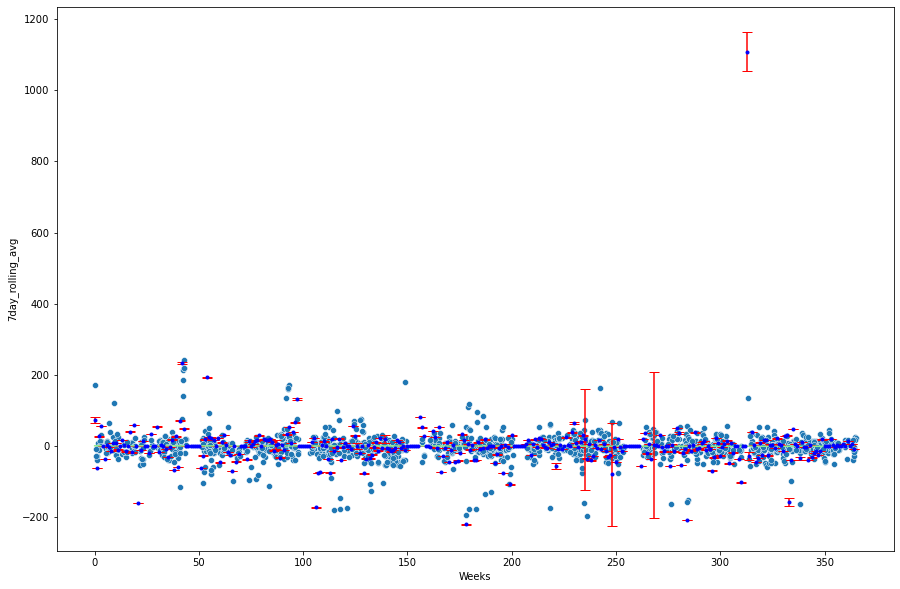

In [61]:
plt.figure(figsize=(15,10))
#sns.scatterplot(x='Weeks', y='ΔRV', data=weightedavg_df_cutoff)
sns.scatterplot(x='Weeks', y='7day_rolling_avg', data=weightedavg_df_cutoff)
x = np.arange(0,365)
y = avg_weeks
yerr = avg_weeks_err
a, b = np.polyfit(x, y, 1)
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
#plt.xlabel('Weeks')
#plt.ylabel('Average ΔRV [m/s]')

<AxesSubplot:xlabel='Weeks', ylabel='ΔRV'>

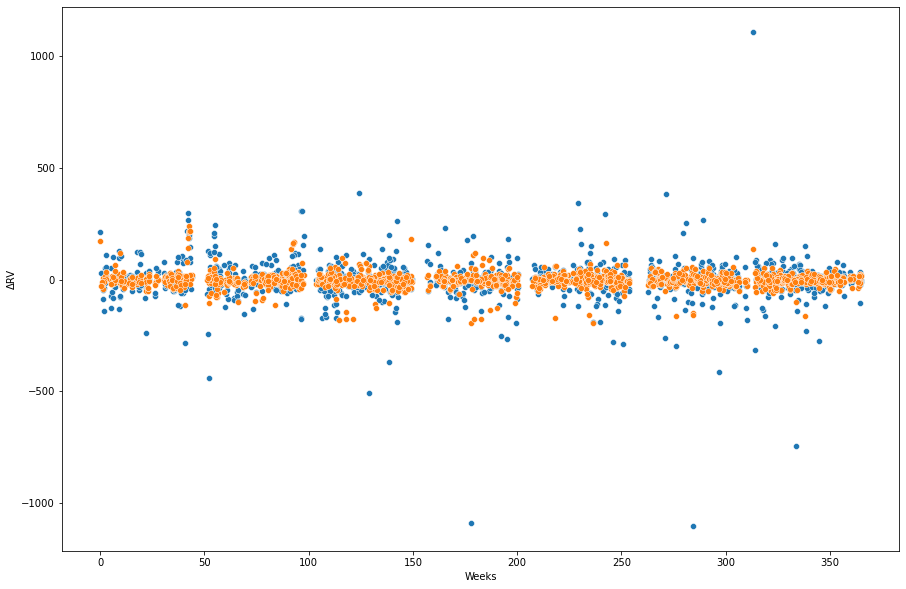

In [62]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='Weeks', y='ΔRV', data=weightedavg_df_cutoff)
sns.scatterplot(x='Weeks', y='7day_rolling_avg', data=weightedavg_df_cutoff)

In [ ]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs = []
combined_staterror = []

for mjd in unique_mjd_list:
    mjd_df = mp_df[mp_df['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    # print('Sum of weights:', sum(weight))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs.append(combined_weightedavg)
    combined_staterror.append(sigmaRV)

In [64]:
from scipy.optimize import curve_fit

In [65]:
def test(x, a, b):
    return a * np.sin(b*x)

In [96]:
param, param_cov = curve_fit(test, x_cf, y_cf)#, sigma=weights)

In [97]:
print("Sine coefficients:", param)
print("Cov of coefficients:", param_cov)

Sine coefficients: [1.06084253 0.99999455]
Cov of coefficients: [[ 9.31972328e+00 -1.15973926e-07]
 [-1.15973926e-07  2.58021651e-09]]


In [98]:
ans = (param[0]*(np.sin(param[1]*x_cf)))

In [99]:
len(ans)

1524

(500.0, -500.0)

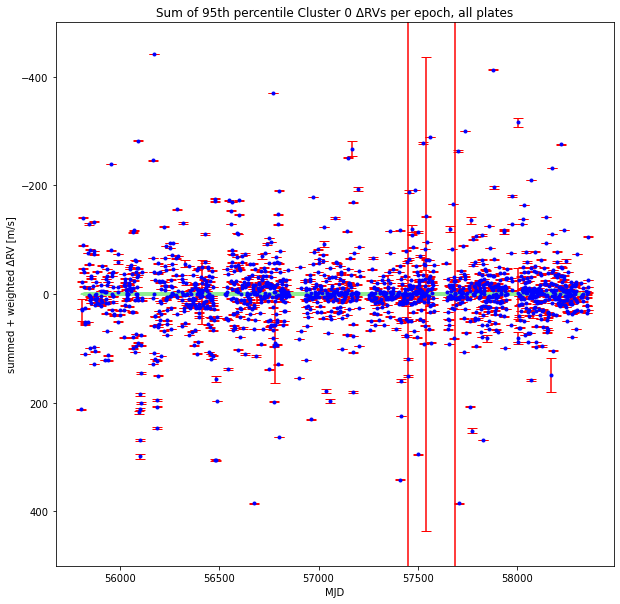

In [103]:
plt.figure(figsize=(10, 10))
plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x_cf, test(x_cf, param[0], param[1]), color='lightgreen')
plt.title('Sum of 95th percentile Cluster 0 ΔRVs per epoch, all plates')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [m/s]')
plt.ylim(500, -500)
#plt.xlim(56500, 56500.000001)

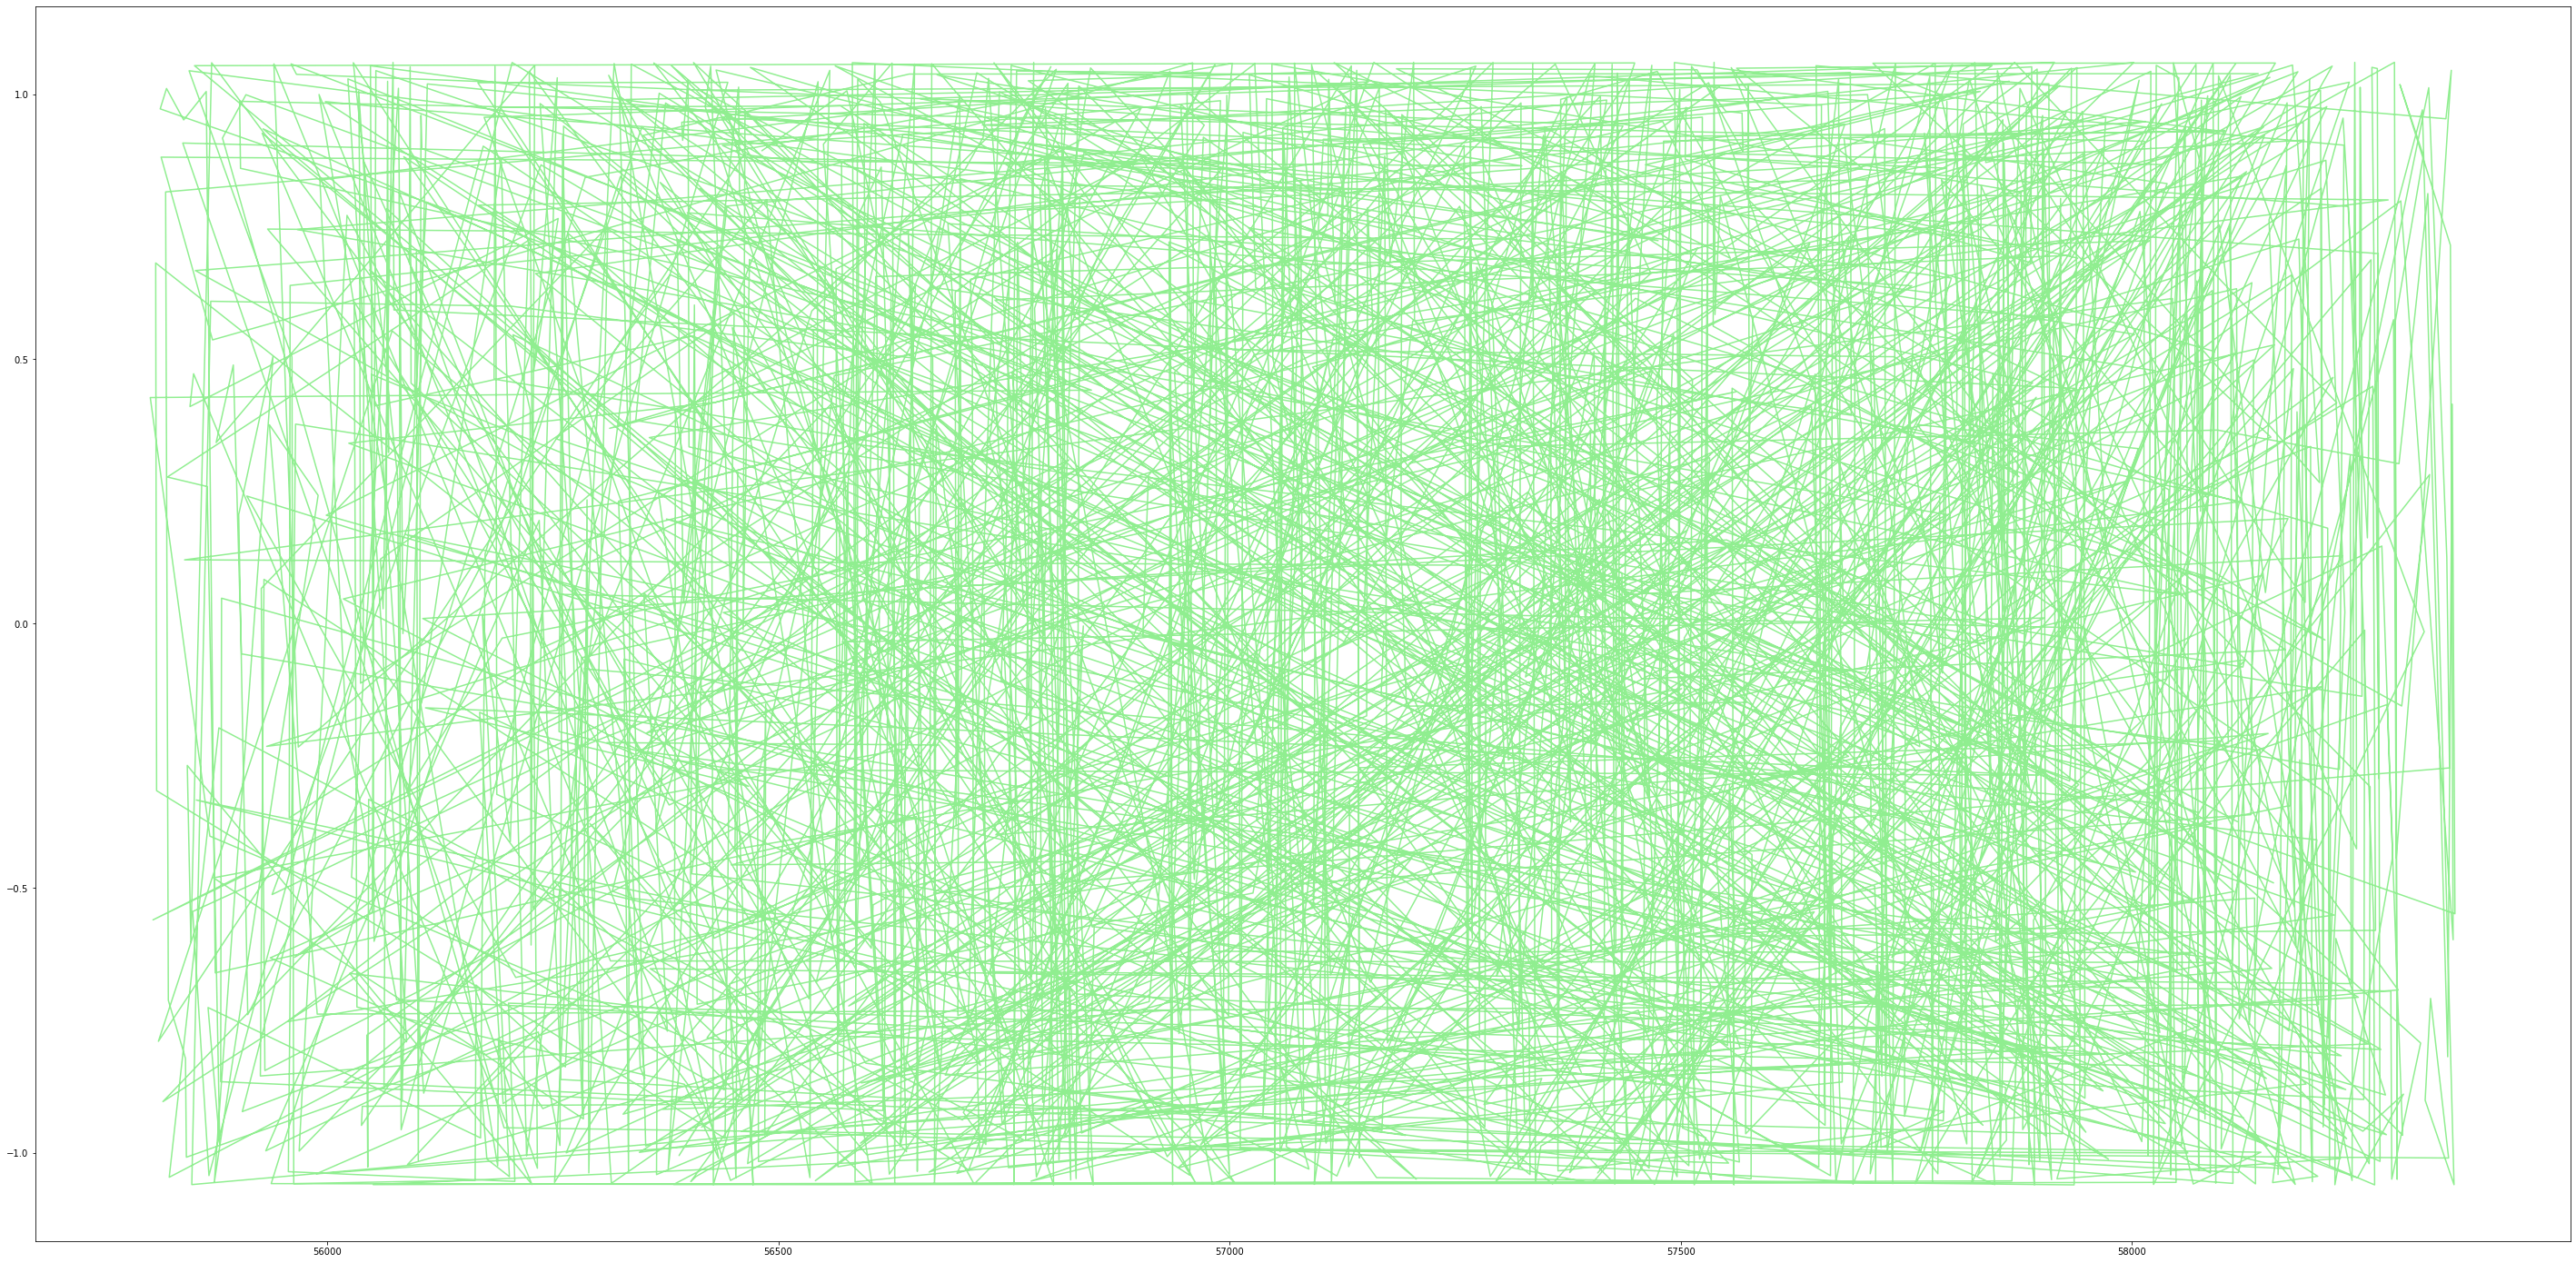

In [104]:
plt.figure(figsize=(50, 25))
plt.plot(x_cf, test(x_cf, param[0], param[1]), color='lightgreen')

mu: -2.351556728498106 std: 84.57216100077585


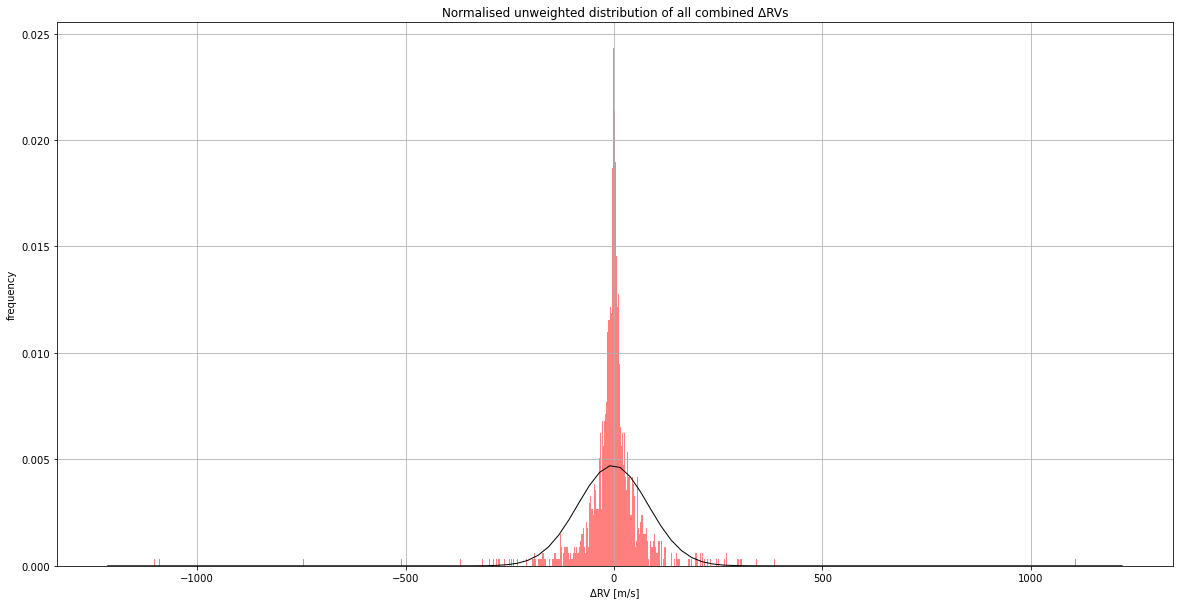

In [63]:
# Normalised unweighted distribution of all combined ΔRVs

mua, stda = norm.fit(weightedavg_df_cutoff['Combined ΔRV (m/s)'])

plt.figure(figsize=(20,10))
plt.hist(x=weightedavg_df_cutoff['Combined ΔRV (m/s)'], bins=1000, alpha=0.5, color='r', label='Cluster 2', density=True, rwidth=1)
xmina, xmaxa = plt.xlim()
xa = np.linspace(xmina, xmaxa, 100)
pa = norm.pdf(xa, mua, stda)  
plt.plot(xa, pa, 'k', linewidth=1)
plt.grid()
plt.title('Normalised unweighted distribution of all combined ΔRVs')
plt.xlabel('ΔRV [m/s]')
plt.ylabel('frequency')
print('mu:', mua, 'std:', stda)